In [1]:
# 目的: 尚未翻轉大腦前，先快速瀏覽1W顆母果蠅腦的左右腦體積誤差率絕對值，輸出圖片進行人工檢查
# 最後還能透過網頁進行標繼成左右腦

# Step1 讀取每一個第五階段資料夾內的切割結果 ================先測試讀取0~1000
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import tifffile as tif
from skimage import measure
from scipy import ndimage
import pandas as pd
import time
start_time_seg = time.time()
# NAS路徑設定
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'

# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()
# 過濾出以 "使用者程序_第五階段存檔內容" 開頭的資料夾
stage_five_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容')]

# =============================先測試0~1000=============================
folder = stage_five_folders[0]
# 未來希望平行化處理 stage_five_folders 所有的資料夾 stage_five_folders[0..1..2..3.....]
folder_path = os.path.join(nas_path, folder)
print('本次處理的資料夾名稱: ',folder_path)
# 搜尋該資料夾內所有的 Label 檔案
label_files = glob.glob(os.path.join(folder_path, 'Seg*'))
label_files.sort()
# label_files 是資料夾內所有切割完成的結果

# Step2 使用 from skimage import measure 透過計算最大和次大的區域質量中心去判斷左右腦

# 紀錄有計算左右腦的檔案名稱
used_files = []
left_volumes = []
right_volumes = []
# ============因為還沒統一拍攝方向，所以左右腦是無法確認，後面只要計算體積誤差絕對值============
for file_path in label_files:
    # 读取文件
    label = tif.imread(file_path)
    
    # 标记连通区域并找到每个区域的属性
    labels = measure.label(label, connectivity=1)
    regions = measure.regionprops(labels)
    
    # 按面积大小排序区域，并选择最大和第二大的区域
    regions_sorted_by_area = sorted(regions, key=lambda x: x.area, reverse=True)
    
    # 如果区域数量不足2，或者最大区域与第二大区域的面积比过大，则跳过
    if len(regions_sorted_by_area) < 2 or regions_sorted_by_area[0].area / regions_sorted_by_area[1].area > 2:
        print(f"Skipping {os.path.basename(file_path)} due to significant area difference between regions.")
        # ===============儲存到 left_volumes 、 right_volumes 列表===============
#         left_volumes.append(0.1)
#         right_volumes.append(0.1)
        continue
    
    # 二值化处理，初始化两个全零数组用于分别保存左腦和右腦
    left_brain = np.zeros_like(label)
    right_brain = np.zeros_like(label)
    
    # 计算这两个区域的质量中心，判断左右脑
    centroid1 = regions_sorted_by_area[0].centroid
    centroid2 = regions_sorted_by_area[1].centroid
    left_index, right_index = (0, 1) if centroid1[2] < centroid2[2] else (1, 0)
    
    # 分别标记左腦和右腦
    for coord in regions_sorted_by_area[left_index].coords:
        left_brain[coord[0], coord[1], coord[2]] = 1
    for coord in regions_sorted_by_area[right_index].coords:
        right_brain[coord[0], coord[1], coord[2]] = 1
    
    # ===============儲存到 left_volumes 、 right_volumes 列表===============
    left_volumes.append(np.sum(left_brain))
    right_volumes.append(np.sum(right_brain))
    # 將有被成功紀錄體積的檔案名稱記錄下來
    used_files.append(file_path.split('/')[-1][:-4])
end_time_seg = time.time()
print("完成，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))

# ===================================平行化測試=================================== 0~~20000
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import tifffile as tif
from skimage import measure
from scipy import ndimage
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
start_time_seg = time.time()
# NAS路徑設定
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'

# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()
# 過濾出以 "使用者程序_第五階段存檔內容" 開頭的資料夾
stage_five_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容')]
# ============================================使用迴圈處理 stage_five_folders 所有資料夾============================================
for iiii in range(len(stage_five_folders)):

    # =============================先測試0~1000=============================
    folder = stage_five_folders[iiii]
    # 未來希望平行化處理 stage_five_folders 所有的資料夾 stage_five_folders[0..1..2..3.....]
    folder_path = os.path.join(nas_path, folder)
    print('本次處理的資料夾名稱: ',folder_path)
    # 搜尋該資料夾內所有的 Label 檔案
    label_files = glob.glob(os.path.join(folder_path, 'Seg*'))
    label_files.sort()

    # 定义处理单个文件的函数
    def process_file(file_path):
        try:
            label = tif.imread(file_path)
            labels = measure.label(label, connectivity=1)
            regions = measure.regionprops(labels)
            regions_sorted_by_area = sorted(regions, key=lambda x: x.area, reverse=True)

            if len(regions_sorted_by_area) < 2 or regions_sorted_by_area[0].area / regions_sorted_by_area[1].area > 2:
                # 返回 None 或其他标志以表示跳过的文件
                return file_path, None, None

            left_brain = np.zeros_like(label)
            right_brain = np.zeros_like(label)

            centroid1 = regions_sorted_by_area[0].centroid
            centroid2 = regions_sorted_by_area[1].centroid
            left_index, right_index = (0, 1) if centroid1[2] < centroid2[2] else (1, 0)

            for coord in regions_sorted_by_area[left_index].coords:
                left_brain[coord[0], coord[1], coord[2]] = 1
            for coord in regions_sorted_by_area[right_index].coords:
                right_brain[coord[0], coord[1], coord[2]] = 1

            return file_path, np.sum(left_brain), np.sum(right_brain)
        except Exception as e:
            return file_path, None, None

    # 使用 ThreadPoolExecutor 来并行处理文件
    with ThreadPoolExecutor(max_workers=8) as executor:
        # 提交所有文件到线程池
        futures = [executor.submit(process_file, file_path) for file_path in label_files]

        # 初始化列表用于存储结果
        used_files = []
        left_volumes = []
        right_volumes = []

        # 等待每个任务完成并处理结果
        for future in as_completed(futures):
            file_path, left_volume, right_volume = future.result()
            if left_volume is not None and right_volume is not None:
                # 根据需要处理有效结果
                used_files.append(file_path.split('/')[-1][:-4])
                left_volumes.append(left_volume)
                right_volumes.append(right_volume)


    # 製作成列表，並計算出 absolute_percentage_differences
    # 转换为浮点型以避免溢出
    left_volumes_float = [float(v) for v in left_volumes]
    right_volumes_float = [float(v) for v in right_volumes]
    # 计算平均体积
    average_volumes = [(lv + rv) / 2.0 for lv, rv in zip(left_volumes_float, right_volumes_float)]

    # 计算体积差异及其百分比
    volume_differences = [rv - lv for lv, rv in zip(left_volumes_float, right_volumes_float)]
    percentage_differences = [100.0 * (diff / avg) for diff, avg in zip(volume_differences, average_volumes)]

    # 取絕對值
    absolute_percentage_differences = [abs(x) for x in percentage_differences]

    # 輸出儲存 used_files & absolute_percentage_differences

    # 从 folder 变量提取范围信息
    range_info = folder.split('母果蠅_')[-1]   # 例如："0_1000"

    # 文件名前缀
    file_name_prefix = range_info  # 例如："0_1000"

    # 保存 used_files 为 .npy 文件
    np.save(f'{file_name_prefix}_有處理的檔案名稱.npy', np.array(used_files))

    # 保存 absolute_percentage_differences 为 .npy 文件
    np.save(f'{file_name_prefix}_有處理的體積誤差百分比.npy', np.array(absolute_percentage_differences))

    print(f"已保存：\n{file_name_prefix}_有處理的檔案名稱.npy\n{file_name_prefix}_有處理的體積誤差百分比.npy")
    end_time_seg = time.time()
    print("完成，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))
    print('=====================================================')

In [4]:
print("完成，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))

完成，总耗时: 42887.27 秒


In [ ]:
# =============================以上已經分析完2W個大腦，不要再執行=============================
# =============================如果要分析20000~28572請另外執行=============================

In [ ]:
# ===================================平行化測試=================================== 20000~~22835
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import tifffile as tif
from skimage import measure
from scipy import ndimage
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
start_time_seg = time.time()
# NAS路徑設定
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'

# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()
# # 過濾出以 "使用者程序_第五階段存檔內容" 開頭的資料夾
# stage_five_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容')]
stage_five_folders = ['使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅_20000_21000',
                      '使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅_21000_22000',
                      '使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅_22000_22835']
# ============================================使用迴圈處理 stage_five_folders 所有資料夾============================================
for iiii in range(len(stage_five_folders)):

    # =============================先測試0~1000=============================
    folder = stage_five_folders[iiii]
    # 未來希望平行化處理 stage_five_folders 所有的資料夾 stage_five_folders[0..1..2..3.....]
    folder_path = os.path.join(nas_path, folder)
    print('本次處理的資料夾名稱: ',folder_path)
    # 搜尋該資料夾內所有的 Label 檔案
    label_files = glob.glob(os.path.join(folder_path, 'Seg*'))
    label_files.sort()

    # 定义处理单个文件的函数
    def process_file(file_path):
        try:
            label = tif.imread(file_path)
            labels = measure.label(label, connectivity=1)
            regions = measure.regionprops(labels)
            regions_sorted_by_area = sorted(regions, key=lambda x: x.area, reverse=True)

            if len(regions_sorted_by_area) < 2 or regions_sorted_by_area[0].area / regions_sorted_by_area[1].area > 2:
                # 返回 None 或其他标志以表示跳过的文件
                return file_path, None, None

            left_brain = np.zeros_like(label)
            right_brain = np.zeros_like(label)

            centroid1 = regions_sorted_by_area[0].centroid
            centroid2 = regions_sorted_by_area[1].centroid
            left_index, right_index = (0, 1) if centroid1[2] < centroid2[2] else (1, 0)

            for coord in regions_sorted_by_area[left_index].coords:
                left_brain[coord[0], coord[1], coord[2]] = 1
            for coord in regions_sorted_by_area[right_index].coords:
                right_brain[coord[0], coord[1], coord[2]] = 1

            return file_path, np.sum(left_brain), np.sum(right_brain)
        except Exception as e:
            return file_path, None, None

    # 使用 ThreadPoolExecutor 来并行处理文件
    with ThreadPoolExecutor(max_workers=8) as executor:
        # 提交所有文件到线程池
        futures = [executor.submit(process_file, file_path) for file_path in label_files]

        # 初始化列表用于存储结果
        used_files = []
        left_volumes = []
        right_volumes = []

        # 等待每个任务完成并处理结果
        for future in as_completed(futures):
            file_path, left_volume, right_volume = future.result()
            if left_volume is not None and right_volume is not None:
                # 根据需要处理有效结果
                used_files.append(file_path.split('/')[-1][:-4])
                left_volumes.append(left_volume)
                right_volumes.append(right_volume)


    # 製作成列表，並計算出 absolute_percentage_differences
    # 转换为浮点型以避免溢出
    left_volumes_float = [float(v) for v in left_volumes]
    right_volumes_float = [float(v) for v in right_volumes]
    # 计算平均体积
    average_volumes = [(lv + rv) / 2.0 for lv, rv in zip(left_volumes_float, right_volumes_float)]

    # 计算体积差异及其百分比
    volume_differences = [rv - lv for lv, rv in zip(left_volumes_float, right_volumes_float)]
    percentage_differences = [100.0 * (diff / avg) for diff, avg in zip(volume_differences, average_volumes)]

    # 取絕對值
    absolute_percentage_differences = [abs(x) for x in percentage_differences]

    # 輸出儲存 used_files & absolute_percentage_differences

    # 从 folder 变量提取范围信息
    range_info = folder.split('母果蠅_')[-1]   # 例如："0_1000"

    # 文件名前缀
    file_name_prefix = range_info  # 例如："0_1000"

    # 保存 used_files 为 .npy 文件
    np.save(f'{file_name_prefix}_有處理的檔案名稱.npy', np.array(used_files))

    # 保存 absolute_percentage_differences 为 .npy 文件
    np.save(f'{file_name_prefix}_有處理的體積誤差百分比.npy', np.array(absolute_percentage_differences))

    print(f"已保存：\n{file_name_prefix}_有處理的檔案名稱.npy\n{file_name_prefix}_有處理的體積誤差百分比.npy")
    end_time_seg = time.time()
    print("完成，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))
    print('=====================================================')

本次處理的資料夾名稱:  /mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅_20000_21000
已保存：
20000_21000_有處理的檔案名稱.npy
20000_21000_有處理的體積誤差百分比.npy
完成，总耗时: 2142.04 秒
本次處理的資料夾名稱:  /mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅_21000_22000
已保存：
21000_22000_有處理的檔案名稱.npy
21000_22000_有處理的體積誤差百分比.npy
完成，总耗时: 4263.17 秒
本次處理的資料夾名稱:  /mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅_22000_22835
已保存：
22000_22835_有處理的檔案名稱.npy
22000_22835_有處理的體積誤差百分比.npy
完成，总耗时: 5993.56 秒


In [ ]:
print("完成，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))

# 測試展示十張圖片觀察
label_files = label_files[108:115]
# 設定圖像大小和布局
fig, axs = plt.subplots(nrows=len(label_files), ncols=1, figsize=(10, len(label_files) * 5))

for ax, file_path in zip(axs, label_files):
    # 讀取檔案
    label = tif.imread(file_path)
    # 執行最大值投影
    label_projected = np.max(label, axis=0)
    
    # 展示影像
    ax.imshow(label_projected, cmap='gray')
    # 設定標題為檔案名
    ax.set_title(os.path.basename(file_path))
    ax.axis('off')  # 不顯示軸

plt.tight_layout()
plt.show()

# 製作成列表，並計算出 absolute_percentage_differences
# 转换为浮点型以避免溢出
left_volumes_float = [float(v) for v in left_volumes]
right_volumes_float = [float(v) for v in right_volumes]
# 计算平均体积
average_volumes = [(lv + rv) / 2.0 for lv, rv in zip(left_volumes_float, right_volumes_float)]

# 计算体积差异及其百分比
volume_differences = [rv - lv for lv, rv in zip(left_volumes_float, right_volumes_float)]
percentage_differences = [100.0 * (diff / avg) for diff, avg in zip(volume_differences, average_volumes)]

# 取絕對值
absolute_percentage_differences = [abs(x) for x in percentage_differences]


# 提取大脑标识符
# brain_identifiers = [file.split('/')[-1][:-4] for file in label_files]
brain_identifiers = used_files
# 创建 DataFrame
df = pd.DataFrame({
    'Brain ID': brain_identifiers,
    'Left Volume': left_volumes_float,
    'Right Volume': right_volumes_float,
    'Average Volume': average_volumes,
    'Volume Difference': volume_differences,
    'Percentage Difference (%)': absolute_percentage_differences
})
print('因為暫時分析只需要調閱percentage_differences')
df

# Step3 將體積誤差百分比(絕對值)繪製分布圖 ================這是繪製單一個1000個大腦的體積誤差率分布圖
import matplotlib.pyplot as plt

absolute_percentage_differences = np.load('0_1000_有處理的體積誤差百分比.npy')
used_files = np.load('0_1000_有處理的檔案名稱.npy')

# 计算百分比差异的平均值和标准差
mean_difference = np.mean(absolute_percentage_differences)
std_deviation = np.std(absolute_percentage_differences)

# 绘制体积差异百分比的分布图
plt.figure(figsize=(20, 12))
plt.hist(absolute_percentage_differences, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_difference, color='r', linestyle='dashed', linewidth=4, label='Mean')
plt.axvline(mean_difference - std_deviation, color='g', linestyle='dashed', linewidth=4, label='±1 STD')
plt.axvline(mean_difference + std_deviation, color='g', linestyle='dashed', linewidth=4)

plt.title('Brain Volume Differences Distribution (%)',size=26)
plt.xlabel('Volume Difference (%)',size=24)
plt.ylabel('Frequency',size=24)
plt.xticks(fontsize=20)  # X轴刻度字体大小
plt.yticks(fontsize=20)  # Y轴刻度字体大小
plt.grid(True)
plt.legend(fontsize='18')

# 显示图表
plt.show()

# # 计算左脑体积大（即百分比差异<0）和右脑体积大（即百分比差异>0）的数量
# left_larger = sum(diff < 0 for diff in percentage_differences)
# right_larger = sum(diff > 0 for diff in percentage_differences)

# print(f"Number of cases where the left brain is larger: {left_larger}")
# print(f"Number of cases where the right brain is larger: {right_larger}")

# 打印平均值和标准差
print(f"Mean Volume Difference (%): {mean_difference}")
print(f"Standard Deviation: {std_deviation}")
print('成功總數量: ',len(absolute_percentage_differences))
# 假设 absolute_percentage_differences 已经被定义并包含了所有元素的绝对值
count_greater_than_10 = len([x for x in absolute_percentage_differences if x >= 10])
print('體積差異>10%數量:',count_greater_than_10, '百分比:',count_greater_than_10/len(absolute_percentage_differences)*100,'%')
count_greater_than_20 = len([x for x in absolute_percentage_differences if x >= 20])
print('體積差異>20%數量:',count_greater_than_20, '百分比:',count_greater_than_20/len(absolute_percentage_differences)*100,'%')


In [ ]:
# ===========================下方可以獨立執行，批量輸出挑選出來的體積差異度>=?% 的影像提供給人工檢驗===========================

In [11]:
finish_filename_list

['./0_1000_有處理的檔案名稱.npy',
 './10000_11000_有處理的檔案名稱.npy',
 './1000_2000_有處理的檔案名稱.npy',
 './11000_12000_有處理的檔案名稱.npy',
 './12000_13000_有處理的檔案名稱.npy',
 './13000_14000_有處理的檔案名稱.npy',
 './14000_15000_有處理的檔案名稱.npy',
 './15000_16000_有處理的檔案名稱.npy',
 './16000_17000_有處理的檔案名稱.npy',
 './17000_18000_有處理的檔案名稱.npy',
 './18000_19000_有處理的檔案名稱.npy',
 './19000_20000_有處理的檔案名稱.npy',
 './20000_21000_有處理的檔案名稱.npy',
 './2000_3000_有處理的檔案名稱.npy',
 './21000_22000_有處理的檔案名稱.npy',
 './22000_22835_有處理的檔案名稱.npy',
 './3000_4000_有處理的檔案名稱.npy',
 './4000_5000_有處理的檔案名稱.npy',
 './5000_6000_有處理的檔案名稱.npy',
 './6000_7000_有處理的檔案名稱.npy',
 './7000_8000_有處理的檔案名稱.npy',
 './8000_9000_有處理的檔案名稱.npy',
 './9000_10000_有處理的檔案名稱.npy']

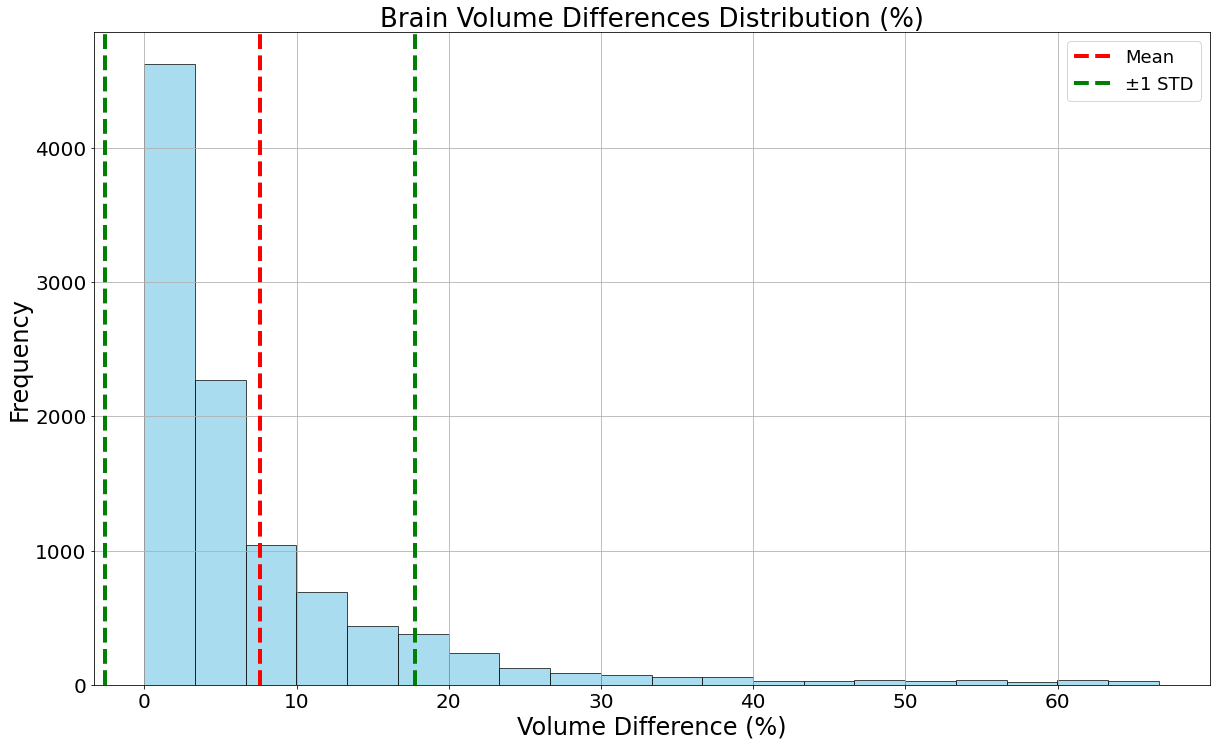

Mean Volume Difference (%): 7.588058863563163
Standard Deviation: 10.166044702906675
讀取的大腦總數:  22835
成功左右腦比對總數量:  10337
成功左右腦比對百分比:  45.268228596452815 %
*成功比對的總數只有5成的主因: 已經去除[失敗、單邊MB、兩個MB有相連]
**大多數去除的來自於單邊MB & 兩個MB有相連(細微相連也會被排除)
體積差異>10%數量: 2404 個 百分比: 23.25626390635581 %
體積差異>20%數量: 890 個 百分比: 8.609848118409596 %
體積差異>30%數量: 435 個 百分比: 4.208184192705814 %
體積差異>40%數量: 249 個 百分比: 2.4088226758247075 %
體積差異>50%數量: 153 個 百分比: 1.4801199574344586 %
體積差異>60%數量: 66 個 百分比: 0.6384831188932959 %


In [8]:
# Step4 將體積誤差率>10的列出來 以及 >20的列出來 ==========================先合併20個列表(名稱一組、體積誤差率一組)共40個列表
# =======================================================
# 先繪製2萬顆大腦的體積誤差率分布圖
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import tifffile as tif
from skimage import measure
from scipy import ndimage
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
start_time_seg = time.time()
# NAS路徑設定
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'

# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()
# 過濾出以 "使用者程序_第五階段存檔內容" 開頭的資料夾
stage_five_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容')]

# 檢查當前資料夾有多少個 體積誤差百分比.npy 檔案
# 搜尋當前資料夾 尾巴有 體積誤差百分比.npy
finish_precentage_list = glob.glob(os.path.join('./', '*有處理的體積誤差百分比.npy'))
finish_precentage_list.sort()
# 要刪除的檔案名稱列表
to_delete = [
 './758個人工驗證完成_need_to_flip_有處理的體積誤差百分比.npy',
 './758個人工驗證完成_no_need_to_flip_有處理的體積誤差百分比.npy',
    './0_1000個人工驗證完成_need_to_flip_母果蠅_有處理的體積誤差百分比.npy',
 './0_1000個人工驗證完成_no_need_to_flip_母果蠅_有處理的體積誤差百分比.npy',
 './0_1331個人工驗證完成_need_to_flip_母果蠅_有處理的體積誤差百分比.npy',
 './0_1331個人工驗證完成_no_need_to_flip_母果蠅_有處理的體積誤差百分比.npy',
 './0_315個人工驗證完成_need_to_flip_母果蠅_有處理的體積誤差百分比.npy',
 './0_315個人工驗證完成_no_need_to_flip_母果蠅_有處理的體積誤差百分比.npy',
    './客製化數據集_有處理的體積誤差百分比.npy'
]

# 使用列表理解來移除特定的檔案名稱
updated_filename_list = [file for file in finish_precentage_list if file not in to_delete]

finish_precentage_list = updated_filename_list
# =
finish_filename_list = glob.glob(os.path.join('./', '*有處理的檔案名稱.npy'))
finish_filename_list.sort()
# 要刪除的檔案名稱列表
to_delete = [
    './758個人工驗證完成_need_to_flip_有處理的檔案名稱.npy',
    './758個人工驗證完成_no_need_to_flip_有處理的檔案名稱.npy',
     './0_1000個人工驗證完成_need_to_flip_母果蠅_有處理的檔案名稱.npy',
 './0_1000個人工驗證完成_no_need_to_flip_母果蠅_有處理的檔案名稱.npy',
 './0_1331個人工驗證完成_need_to_flip_母果蠅_有處理的檔案名稱.npy',
 './0_1331個人工驗證完成_no_need_to_flip_母果蠅_有處理的檔案名稱.npy',
 './0_315個人工驗證完成_need_to_flip_母果蠅_有處理的檔案名稱.npy',
 './0_315個人工驗證完成_no_need_to_flip_母果蠅_有處理的檔案名稱.npy',
    './客製化數據集_有處理的檔案名稱.npy'
    
]

# 使用列表理解來移除特定的檔案名稱
updated_filename_list = [file for file in finish_filename_list if file not in to_delete]

finish_filename_list = updated_filename_list
# 將體積誤差百分比(絕對值)繪製分布圖 ================這是繪製單一個1000個大腦的體積誤差率分布圖
# Initialize empty lists to store the loaded arrays
absolute_percentage_differences = []
used_files = []

# Load and concatenate the arrays for volume percentage differences
for file in finish_precentage_list:
    data = np.load(file)
    absolute_percentage_differences.append(data)

# Concatenate all arrays into one
absolute_percentage_differences = np.concatenate(absolute_percentage_differences, axis=0)

# Load and concatenate the arrays for used file names
for file in finish_filename_list:
    data = np.load(file)
    used_files.append(data)

# Concatenate all arrays into one
used_files = np.concatenate(used_files, axis=0)


# 计算百分比差异的平均值和标准差
mean_difference = np.mean(absolute_percentage_differences)
std_deviation = np.std(absolute_percentage_differences)

# 绘制体积差异百分比的分布图
plt.figure(figsize=(20, 12))
plt.hist(absolute_percentage_differences, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_difference, color='r', linestyle='dashed', linewidth=4, label='Mean')
plt.axvline(mean_difference - std_deviation, color='g', linestyle='dashed', linewidth=4, label='±1 STD')
plt.axvline(mean_difference + std_deviation, color='g', linestyle='dashed', linewidth=4)

plt.title('Brain Volume Differences Distribution (%)',size=26)
plt.xlabel('Volume Difference (%)',size=24)
plt.ylabel('Frequency',size=24)
plt.xticks(fontsize=20)  # X轴刻度字体大小
plt.yticks(fontsize=20)  # Y轴刻度字体大小
plt.grid(True)
plt.legend(fontsize='18')

# 显示图表
plt.show()

# # 计算左脑体积大（即百分比差异<0）和右脑体积大（即百分比差异>0）的数量
# left_larger = sum(diff < 0 for diff in percentage_differences)
# right_larger = sum(diff > 0 for diff in percentage_differences)

# print(f"Number of cases where the left brain is larger: {left_larger}")
# print(f"Number of cases where the right brain is larger: {right_larger}")

# 打印平均值和标准差
print(f"Mean Volume Difference (%): {mean_difference}")
print(f"Standard Deviation: {std_deviation}")
print('讀取的大腦總數: ','22835')
print('成功左右腦比對總數量: ',len(absolute_percentage_differences))
print('成功左右腦比對百分比: ',len(absolute_percentage_differences)/(22835)*100,'%')
print('*成功比對的總數只有5成的主因: 已經去除[失敗、單邊MB、兩個MB有相連]')
print('**大多數去除的來自於單邊MB & 兩個MB有相連(細微相連也會被排除)')
print('===============')
# 假设 absolute_percentage_differences 已经被定义并包含了所有元素的绝对值
count_greater_than_10 = len([x for x in absolute_percentage_differences if x >= 10])
print('體積差異>10%數量:',count_greater_than_10, '個 百分比:',count_greater_than_10/len(absolute_percentage_differences)*100,'%')
count_greater_than_20 = len([x for x in absolute_percentage_differences if x >= 20])
print('體積差異>20%數量:',count_greater_than_20, '個 百分比:',count_greater_than_20/len(absolute_percentage_differences)*100,'%')
count_greater_than_30 = len([x for x in absolute_percentage_differences if x >= 30])
print('體積差異>30%數量:',count_greater_than_30, '個 百分比:',count_greater_than_30/len(absolute_percentage_differences)*100,'%')
count_greater_than_40 = len([x for x in absolute_percentage_differences if x >= 40])
print('體積差異>40%數量:',count_greater_than_40, '個 百分比:',count_greater_than_40/len(absolute_percentage_differences)*100,'%')
count_greater_than_50 = len([x for x in absolute_percentage_differences if x >= 50])
print('體積差異>50%數量:', count_greater_than_50, '個 百分比:', count_greater_than_50 / len(absolute_percentage_differences) * 100, '%')
count_greater_than_60 = len([x for x in absolute_percentage_differences if x >= 60])
print('體積差異>60%數量:', count_greater_than_60, '個 百分比:', count_greater_than_60 / len(absolute_percentage_differences) * 100, '%')




# =======================================================
# 先評估10% 以上的數量 和 20%以上的數量，
# 將百分比閾值以上的體積誤差率輸出DLG & SEG投影圖(參考Step6輸出2D合併圖、最後在使用網頁提供人工確認(Step7))

In [18]:
# Step5 批量輸出758個 左右腦體積差異>20%的合併圖(DLG+SEG圖)
# 找到絕對百分比差異 >= 20 的索引
indices = np.where(absolute_percentage_differences >= 20)[0] # ===============================這裡可以修改要調查多少體積差異%以上的圖片

# 輸出對應的檔案名稱
differences_big_then20_files = []
for index in indices:
    differences_big_then20_files.append(used_files[index])
# 用於存儲檔案路徑的字典
file_paths = {}

# 遍歷檔案名稱列表
for file_name in differences_big_then20_files:
    # filename 沒有包含附檔案名稱
    file_name_with_tif = file_name+'.tif'
    found = False
    # 對每個檔案名稱，檢查所有資料夾
    for folder in stage_five_folders:
        potential_path = os.path.join(nas_path, folder, file_name_with_tif)
        # 檢查檔案是否存在於當前資料夾
        if os.path.exists(potential_path):
            file_paths[file_name] = potential_path
            found = True
            break

# # 打印結果或進行後續處理
# for file_name, path in file_paths.items():
#     print(f"{file_name}: {path}")
# 已經提取到 758個檔案的SEG路徑
print('已經提取到',len(differences_big_then20_files),'個檔案的SEG路徑')
print('請將提取到的數字和上面分布圖的統計數字比對是否相等')

已經提取到 758 個檔案的SEG路徑
請將提取到的數字和上面分布圖的統計數字比對是否相等


# Step6 開始批量輸出圖片至 Female_Seg_correctly_758_in_2W 資料夾
import numpy as np
import os
from PIL import Image
import tifffile as tif
import time  # 導入 time 模塊
def normalize_image(image):
    """
    归一化图像到0到255的范围。
    """
    # 计算图像的最大值和最小值
    min_val = np.min(image)
    max_val = np.max(image)
    # 归一化到0-1
    normalized_image = (image - min_val) / (max_val - min_val)
    # 缩放到0-255并转换为整数
    scaled_image = (normalized_image * 255).astype(np.uint8)
    return scaled_image
# 設定輸出資料夾
output_folder = "Female_Seg_correctly_758_in_2W"
output_dir = os.path.join(output_folder)
# 清空並創建 使用者程序_第一階段存檔內容_YOLO提取DLG 資料夾
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
else:
    for file in os.listdir(output_dir):
        os.remove(output_dir+'/' + file)
start_time = time.time()  # 記錄迴圈開始的時間
for file_name in differences_big_then20_files:
    seg_path = file_paths[file_name]
    # 將Seg路徑替換為DLG路徑
    dlg_path = seg_path.replace('Seg_MB', 'DLG')
    
    # 讀取圖像
    dlg_image = tif.imread(dlg_path)
    seg_image = tif.imread(seg_path)
    
    # 投影和归一化图像
    dlg_projection = np.sum(dlg_image[:len(dlg_image)//3, :, :], axis=0)
    seg_projection = np.sum(seg_image, axis=0)
    
    dlg_projection_normalized = normalize_image(dlg_projection)
    seg_projection_normalized = normalize_image(seg_projection)
    
    # 合并图像
    combined_image = np.concatenate((dlg_projection_normalized, seg_projection_normalized), axis=1)
    
    # 儲存合併後的圖像，文件名使用SEG文件名去除前缀和文件扩展名
    save_file_name = file_name.split('_')[2] + '.png'  # 從 'Seg_MB_104198-F-200004' 獲得 '104198-F-200004.png'
    save_path = os.path.join(output_dir, save_file_name)
    Image.fromarray(combined_image).save(save_path)
end_time = time.time()  # 記錄迴圈結束的時間
total_time = end_time - start_time  # 計算總耗時
print(f"批量處理完成，已合併並輸出 {len(differences_big_then20_files)} 張圖像。耗時: {total_time} 秒")


In [18]:
print(f"批量處理完成，已合併並輸出 {len(differences_big_then20_files)} 張圖像。耗時: {total_time} 秒")

批量處理完成，已合併並輸出 758 張圖像。耗時: 8122.627600908279 秒


In [ ]:
# ===================以上已經輸出了本次特別調查的合併圖至資料夾，開始人工驗證===================

In [42]:
# Step7 只須執行此段即可進行人工驗證================
# =============最終正式版本
# 5-HT1B-F-400000.png
# 5-HT1B-F-000005,5-HT1B-F-000004 這兩個DLG一樣，只差在單一神經元拍不同張
import os
import shutil
import base64
from dash import Dash, html, dcc, Input, Output, State
from jupyter_dash import JupyterDash
import dash
from PIL import Image
import io

# 設定資料夹
output_folder = "Female_Seg_correctly_758_in_2W"
no_mb_folder = os.path.join(output_folder, 'No_MB_in_DLG')
segmb_failed_folder = os.path.join(output_folder, 'SegMB_failed')
single_mb_folder = os.path.join(output_folder, 'Single_MB')  # 新增
need_to_flip_folder = os.path.join(output_folder, 'Need_to_flip')  # 新增
no_need_to_flip_folder = os.path.join(output_folder, 'No_Need_to_flip')  # 新增

# 创建新的文件夹，如果不存在的话
for folder in [segmb_failed_folder, no_mb_folder, single_mb_folder, need_to_flip_folder,no_need_to_flip_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# 获取所有图片文件并排序
Done_2D_DLG_Seg = [f for f in sorted(os.listdir(output_folder)) if f.endswith('.png')]

app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Store(id='image-index', data=0),
    dcc.Store(id='review-stage', data='mb_check'),
    html.H1(id='page-title', children="Is there MB in DLG?"),
    html.Div(id='image-name', children=''),
    html.Img(id='image-display', src=''),
    html.Button("YES", id='button-yes', n_clicks=0, style={'width': '150px', 'height': '50px', 'fontSize': '20px', 'margin': '10px'}),
    html.Button("NO", id='button-no', n_clicks=0, style={'width': '150px', 'height': '50px', 'fontSize': '20px', 'margin': '10px'}),
    html.Div(id='image-count', style={'marginTop': '20px'}),
], style={'textAlign': 'center'})


@app.callback(
    [Output('image-display', 'src'),
     Output('image-name', 'children'),
     Output('page-title', 'children'),
     Output('review-stage', 'data'),
     Output('image-count', 'children')],
    [Input('button-yes', 'n_clicks'),
     Input('button-no', 'n_clicks')],
    [State('review-stage', 'data')]
)
def update_image_display(btn_yes, btn_no, stage):
    # 获取所有图片文件并排序
    Done_2D_DLG_Seg = [f for f in sorted(os.listdir(output_folder)) if f.endswith('.png')]
    ctx = dash.callback_context
    if not ctx.triggered:
        stage = 'mb_check'
    else:
        button_id = ctx.triggered[0]['prop_id'].split('.')[0]
        if button_id == 'button-yes':
            if stage == 'mb_check':
                stage = 'segmb_check'
            elif stage == 'segmb_check':
                stage = 'single_mb_check'  # 进入第三页
            elif stage == 'single_mb_check':
                # 移动图片到 Single_MB 文件夹
                src_path = os.path.join(output_folder, Done_2D_DLG_Seg[0])
                dst_path = os.path.join(single_mb_folder, Done_2D_DLG_Seg[0])
                shutil.move(src_path, dst_path)
                stage = 'mb_check'  # 返回第一阶段
            elif stage == 'need_to_flip_check':
                # 移动图片到 Need_to_flip 文件夹
                src_path = os.path.join(output_folder, Done_2D_DLG_Seg[0])
                dst_path = os.path.join(need_to_flip_folder, Done_2D_DLG_Seg[0])
                shutil.move(src_path, dst_path)
                stage = 'mb_check'  # 返回第一阶段
        elif button_id == 'button-no':
            if stage == 'mb_check':
                src_path = os.path.join(output_folder, Done_2D_DLG_Seg[0])
                dst_path = os.path.join(no_mb_folder, Done_2D_DLG_Seg[0])
                shutil.move(src_path, dst_path)
                stage = 'mb_check' # 返回第一阶段
            elif stage == 'segmb_check':
                src_path = os.path.join(output_folder, Done_2D_DLG_Seg[0])
                dst_path = os.path.join(segmb_failed_folder, Done_2D_DLG_Seg[0])
                shutil.move(src_path, dst_path)

                stage = 'mb_check' # 返回第一阶段
            elif stage == 'single_mb_check':
                stage = 'need_to_flip_check' # 进入第四页
            elif stage == 'need_to_flip_check':
                # 移动图片到 No_Need_to_flip 文件夹
                # ================================================
                src_path = os.path.join(output_folder, Done_2D_DLG_Seg[0])
                dst_path = os.path.join(no_need_to_flip_folder, Done_2D_DLG_Seg[0])
                shutil.move(src_path, dst_path)

                stage = 'mb_check' # 返回第一阶段，准备下一张图片
    # 获取所有图片文件并排序
    Done_2D_DLG_Seg = [f for f in sorted(os.listdir(output_folder)) if f.endswith('.png')]
    # 生成新图像的base64编码和文件名
    if Done_2D_DLG_Seg !=[]:
        file_path = os.path.join(output_folder, Done_2D_DLG_Seg[0])
        encoded_image = base64.b64encode(open(file_path, 'rb').read()).decode('ascii')
        src_data = f'data:image/png;base64,{encoded_image}'
    else:
        # 如果所有图片都已经审核完毕
        return dash.no_update, '所有图片审核完毕', dash.no_update, dash.no_update, dash.no_update, dash.no_update

    # 更新页面标题
    if stage == 'mb_check':
        page_title = "Is there MB in DLG?"
    elif stage == 'segmb_check':
        page_title = "Is Seg MB correct?"
    elif stage == 'single_mb_check':
        page_title = "Is it a single MB?"
    elif stage == 'need_to_flip_check':
        page_title = "Need to flip?"
        
    # 计算剩余未处理图片数量
    remaining_images = len(Done_2D_DLG_Seg)
    # 更新页面底部的未处理图片数量
    image_count_text = f"Remaining images to process: {remaining_images}"

    return src_data, Done_2D_DLG_Seg[0], page_title, stage, image_count_text
app.run_server(mode='external', port=14062, host='0.0.0.0')

Dash app running on http://0.0.0.0:14062/


In [1]:
# Step8  先計算暫時分析準確度: 1- (SegMB_failed總數/ (758-No_MB_in_DLG){這是總體-沒有MB的}) *100%
import os
import time
# Define the paths to the two directories
dir_path_segmb_failed = "Female_Seg_correctly_758_in_2W/SegMB_failed"
dir_path_no_mb_in_dlg = "Female_Seg_correctly_758_in_2W/No_MB_in_DLG"

# Function to count files in a directory
def count_files_in_directory(directory_path):
    return len([name for name in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, name))])

# Count files in each directory
segmb_failed_count = count_files_in_directory(dir_path_segmb_failed)
no_mb_in_dlg_count = count_files_in_directory(dir_path_no_mb_in_dlg)

# Calculate accuracy
accuracy = (1 - (segmb_failed_count / (758 - no_mb_in_dlg_count))) * 100

print("失敗的數量: ",segmb_failed_count)
print("原始無MB的數量: ",no_mb_in_dlg_count)
print("成功切割數量百分比: ",round(accuracy,3),"%")

失敗的數量:  84
原始無MB的數量:  7
成功切割數量百分比:  88.815 %


In [13]:
# ================================

In [14]:
# 完成人工驗證後需要針對需要翻轉的DLG檔案進行翻轉，翻轉後再進行一次分析左右腦分布圖

# 讀取 Female_Seg_correctly_758_in_2W/Need_to_flip 裡面的檔案名稱 建立一個 Need_to_flip_list
# 讀取 Female_Seg_correctly_758_in_2W/No_Need_to_flip 裡面的檔案名稱 建立一個 No_Need_to_flip_list
# 尋找 Need_to_flip_list & No_Need_to_flip_list 的Seg檔案絕對路徑 輸出 Need_to_flip_path_list & No_Need_to_flip_path_list

# 使用上方平行化代碼讀取 Need_to_flip_path_list 檔案並使用Step4中的Step2 翻轉後再讀取 No_Need_to_flip_path_list 的檔案去分析左右腦大小差異
# **使用平行化代碼時: 
# 注意folder = stage_five_folders[iiii] 移除，要注意輸出npy檔案名稱要自己撰寫(原本使用folder)
# 注意label_files 就是所有要讀取的檔案路徑 ，但一如果是 Need_to_flip_path_list 需要讀取後翻轉在計算
# 注意從平行化內的單個文件處理: label = tif.imread(file_path) 這裡要判斷file_path是否屬於 Need_to_flip_path_list，要記得翻轉(判斷句)

In [2]:
# Step9 先找到需要翻轉和不用翻轉的檔案的絕對路徑
import os
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'

# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()
# 假定的 NAS 路徑
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'

# 設定資料夾路徑
need_to_flip_dir = os.path.join("Female_Seg_correctly_758_in_2W", "Need_to_flip")
no_need_to_flip_dir = os.path.join("Female_Seg_correctly_758_in_2W", "No_Need_to_flip")

# # 讀取檔案名稱，建立列表
# def read_filenames_from_directory(directory_path):
#     return [name for name in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, name))]
# 讀取檔案名稱，建立列表，去除副檔名並加前綴 "Seg_MB_"
def read_filenames_from_directory_with_prefix(directory_path):
    return ["Seg_MB_" + os.path.splitext(name)[0] for name in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, name))]


Need_to_flip_list = read_filenames_from_directory_with_prefix(need_to_flip_dir)
No_Need_to_flip_list = read_filenames_from_directory_with_prefix(no_need_to_flip_dir)

# 搜尋並映射檔案路徑
def find_file_paths(file_names, search_folders, nas_path):
    file_paths = {}
    for file_name in file_names:
        file_name_with_ext = file_name+'.tif'
#         file_name_with_ext = file_name  # 假定檔案名已包含副檔名
        found = False
        for folder in search_folders:
            potential_path = os.path.join(nas_path, folder, file_name_with_ext)
            if os.path.exists(potential_path):
                file_paths[file_name] = potential_path
                found = True
                break
    return file_paths

# 需要搜尋的資料夾列表
# 過濾出以 "使用者程序_第五階段存檔內容" 開頭的資料夾
search_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容')]

# 尋找並建立路徑列表
Need_to_flip_path_list = find_file_paths(Need_to_flip_list, search_folders, nas_path)
No_Need_to_flip_path_list = find_file_paths(No_Need_to_flip_list, search_folders, nas_path)

# 從 Need_to_flip_path_list 字典中提取絕對路徑
need_to_flip_path_values = list(Need_to_flip_path_list.values())
# 從 No_Need_to_flip_path_list 字典中提取絕對路徑
no_need_to_flip_path_values = list(No_Need_to_flip_path_list.values())


In [15]:
Need_to_flip_list

['Seg_MB_Gad1-F-700141',
 'Seg_MB_Cha-F-300009',
 'Seg_MB_Gad1-F-300454',
 'Seg_MB_Gad1-F-500173',
 'Seg_MB_Cha-F-000157',
 'Seg_MB_Gad1-F-600093',
 'Seg_MB_Gad1-F-200704',
 'Seg_MB_Cha-F-300008',
 'Seg_MB_Cha-F-100109',
 'Seg_MB_Gad1-F-800145',
 'Seg_MB_Tdc2-F-000017',
 'Seg_MB_Gad1-F-500172',
 'Seg_MB_Cha-F-800059',
 'Seg_MB_VGlut-F-500688',
 'Seg_MB_Tdc2-F-300041',
 'Seg_MB_Gad1-F-200703',
 'Seg_MB_Gad1-F-500653',
 'Seg_MB_Gad1-F-500414',
 'Seg_MB_Gad1-F-600092',
 'Seg_MB_Trh-F-100025',
 'Seg_MB_Tdc2-F-000018',
 'Seg_MB_Gad1-F-000362',
 'Seg_MB_Gad1-F-600086',
 'Seg_MB_Tdc2-F-000012',
 'Seg_MB_Tdc2-F-200062',
 'Seg_MB_Gad1-F-600148',
 'Seg_MB_Gad1-F-500654',
 'Seg_MB_VGlut-F-500689',
 'Seg_MB_Cha-F-000159',
 'Seg_MB_Tdc2-F-200041',
 'Seg_MB_Gad1-F-400184',
 'Seg_MB_Cha-F-000126',
 'Seg_MB_Cha-F-300007',
 'Seg_MB_Gad1-F-500163',
 'Seg_MB_Cha-F-000158',
 'Seg_MB_Cha-F-300414',
 'Seg_MB_Gad1-F-200702']

In [10]:
len(no_need_to_flip_path_values)

123

In [11]:
len(need_to_flip_path_values)

37

In [18]:
# Step10 
# 使用上方平行化代碼讀取 Need_to_flip_path_list 檔案並使用Step4中的Step2 翻轉後再讀取 No_Need_to_flip_path_list 的檔案去分析左右腦大小差異
# **使用平行化代碼時: 
# 注意folder = stage_five_folders[iiii] 移除，要注意輸出npy檔案名稱要自己撰寫(原本使用 folder)
# 注意label_files 就是所有要讀取的檔案路徑 ，但一如果是 Need_to_flip_path_list 需要讀取後翻轉在計算
# 注意從平行化內的單個文件處理: label = tif.imread(file_path) 這裡要判斷file_path是否屬於 Need_to_flip_path_list，要記得翻轉(判斷句)


# 先處理無須翻轉的部分 ================= no_need_to_flip_path_values
# 將所有要讀取的檔案路徑放到 label_files
# 搜尋該資料夾內所有的 Label 檔案
label_files = no_need_to_flip_path_values
label_files.sort()
start_time_seg = time.time()
# 定义处理单个文件的函数
def process_file(file_path):
    try:
        label = tif.imread(file_path)
        labels = measure.label(label, connectivity=1)
        regions = measure.regionprops(labels)
        regions_sorted_by_area = sorted(regions, key=lambda x: x.area, reverse=True)

        if len(regions_sorted_by_area) < 2 or regions_sorted_by_area[0].area / regions_sorted_by_area[1].area > 2:
            # 返回 None 或其他标志以表示跳过的文件
            return file_path, None, None

        left_brain = np.zeros_like(label)
        right_brain = np.zeros_like(label)

        centroid1 = regions_sorted_by_area[0].centroid
        centroid2 = regions_sorted_by_area[1].centroid
        left_index, right_index = (0, 1) if centroid1[2] < centroid2[2] else (1, 0)

        for coord in regions_sorted_by_area[left_index].coords:
            left_brain[coord[0], coord[1], coord[2]] = 1
        for coord in regions_sorted_by_area[right_index].coords:
            right_brain[coord[0], coord[1], coord[2]] = 1

        return file_path, np.sum(left_brain), np.sum(right_brain)
    except Exception as e:
        return file_path, None, None

# 使用 ThreadPoolExecutor 来并行处理文件
with ThreadPoolExecutor(max_workers=8) as executor:
    # 提交所有文件到线程池
    futures = [executor.submit(process_file, file_path) for file_path in label_files]

    # 初始化列表用于存储结果
    used_files = []
    left_volumes = []
    right_volumes = []

    # 等待每个任务完成并处理结果
    for future in as_completed(futures):
        file_path, left_volume, right_volume = future.result()
        if left_volume is not None and right_volume is not None:
            # 根据需要处理有效结果
            used_files.append(file_path.split('/')[-1][:-4])
            left_volumes.append(left_volume)
            right_volumes.append(right_volume)


# 製作成列表，並計算出 absolute_percentage_differences
# 转换为浮点型以避免溢出
left_volumes_float = [float(v) for v in left_volumes]
right_volumes_float = [float(v) for v in right_volumes]
# 计算平均体积
average_volumes = [(lv + rv) / 2.0 for lv, rv in zip(left_volumes_float, right_volumes_float)]

# 计算体积差异及其百分比
volume_differences = [rv - lv for lv, rv in zip(left_volumes_float, right_volumes_float)]
percentage_differences = [100.0 * (diff / avg) for diff, avg in zip(volume_differences, average_volumes)]

# 取絕對值
absolute_percentage_differences = [abs(x) for x in percentage_differences]

# 輸出儲存 used_files & absolute_percentage_differences


# 文件名前缀
file_name_prefix = '758個人工驗證完成_no_need_to_flip'  # 例如："0_1000"

# 保存 used_files 为 .npy 文件
np.save(f'{file_name_prefix}_有處理的檔案名稱.npy', np.array(used_files))

# # 保存 absolute_percentage_differences 为 .npy 文件
# np.save(f'{file_name_prefix}_有處理的體積誤差百分比.npy', np.array(absolute_percentage_differences))

# 保存 percentage_differences 为 .npy 文件
np.save(f'{file_name_prefix}_有處理的體積誤差百分比.npy', np.array(percentage_differences))


print(f"已保存：\n{file_name_prefix}_有處理的檔案名稱.npy\n{file_name_prefix}_有處理的體積誤差百分比.npy")
end_time_seg = time.time()
print("完成，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))
print('=====================================================')

已保存：
758個人工驗證完成_no_need_to_flip_有處理的檔案名稱.npy
758個人工驗證完成_no_need_to_flip_有處理的體積誤差百分比.npy
完成，总耗时: 260.99 秒


In [37]:
# Step11 接著處理要翻轉的部分
# 先處理無須翻轉的部分 ================= need_to_flip_path_values
# 將所有要讀取的檔案路徑放到 label_files
# 搜尋該資料夾內所有的 Label 檔案
label_files = need_to_flip_path_values
label_files.sort()
start_time_seg = time.time()
# 定义处理单个文件的函数 =================這裡要修改翻轉
def process_file(file_path):
    try:
        label = tif.imread(file_path)
        # 沿著 Z 軸翻轉
#         label = label[::-1]
        labels = measure.label(label, connectivity=1)
        regions = measure.regionprops(labels)
        regions_sorted_by_area = sorted(regions, key=lambda x: x.area, reverse=True)

        if len(regions_sorted_by_area) < 2 or regions_sorted_by_area[0].area / regions_sorted_by_area[1].area > 2:
            # 返回 None 或其他标志以表示跳过的文件
            return file_path, None, None

        left_brain = np.zeros_like(label)
        right_brain = np.zeros_like(label)

        centroid1 = regions_sorted_by_area[0].centroid
        centroid2 = regions_sorted_by_area[1].centroid
        # 只需要改這裡================= 需要翻轉改成 >   原本是{<}
        left_index, right_index = (0, 1) if centroid1[2] > centroid2[2] else (1, 0)

        for coord in regions_sorted_by_area[left_index].coords:
            left_brain[coord[0], coord[1], coord[2]] = 1
        for coord in regions_sorted_by_area[right_index].coords:
            right_brain[coord[0], coord[1], coord[2]] = 1

        return file_path, np.sum(left_brain), np.sum(right_brain)
    except Exception as e:
        return file_path, None, None

# 使用 ThreadPoolExecutor 来并行处理文件
with ThreadPoolExecutor(max_workers=8) as executor:
    # 提交所有文件到线程池
    futures = [executor.submit(process_file, file_path) for file_path in label_files]

    # 初始化列表用于存储结果
    used_files = []
    left_volumes = []
    right_volumes = []

    # 等待每个任务完成并处理结果
    for future in as_completed(futures):
        file_path, left_volume, right_volume = future.result()
        if left_volume is not None and right_volume is not None:
            # 根据需要处理有效结果
            used_files.append(file_path.split('/')[-1][:-4])
            left_volumes.append(left_volume)
            right_volumes.append(right_volume)


# 製作成列表，並計算出 absolute_percentage_differences
# 转换为浮点型以避免溢出
left_volumes_float = [float(v) for v in left_volumes]
right_volumes_float = [float(v) for v in right_volumes]
# 计算平均体积
average_volumes = [(lv + rv) / 2.0 for lv, rv in zip(left_volumes_float, right_volumes_float)]

# 计算体积差异及其百分比
volume_differences = [rv - lv for lv, rv in zip(left_volumes_float, right_volumes_float)]
percentage_differences = [100.0 * (diff / avg) for diff, avg in zip(volume_differences, average_volumes)]

# 取絕對值
absolute_percentage_differences = [abs(x) for x in percentage_differences]

# 輸出儲存 used_files & absolute_percentage_differences


# 文件名前缀
file_name_prefix = '758個人工驗證完成_need_to_flip'  # 例如："0_1000"

# 保存 used_files 为 .npy 文件
np.save(f'{file_name_prefix}_有處理的檔案名稱.npy', np.array(used_files))

# # 保存 absolute_percentage_differences 为 .npy 文件
# np.save(f'{file_name_prefix}_有處理的體積誤差百分比.npy', np.array(absolute_percentage_differences))

# 保存 percentage_differences 为 .npy 文件
np.save(f'{file_name_prefix}_有處理的體積誤差百分比.npy', np.array(percentage_differences))


print(f"已保存：\n{file_name_prefix}_有處理的檔案名稱.npy\n{file_name_prefix}_有處理的體積誤差百分比.npy")
end_time_seg = time.time()
print("完成，总耗时: {:.2f} 秒".format(end_time_seg - start_time_seg))
print('=====================================================')

已保存：
758個人工驗證完成_need_to_flip_有處理的檔案名稱.npy
758個人工驗證完成_need_to_flip_有處理的體積誤差百分比.npy
完成，总耗时: 57.80 秒


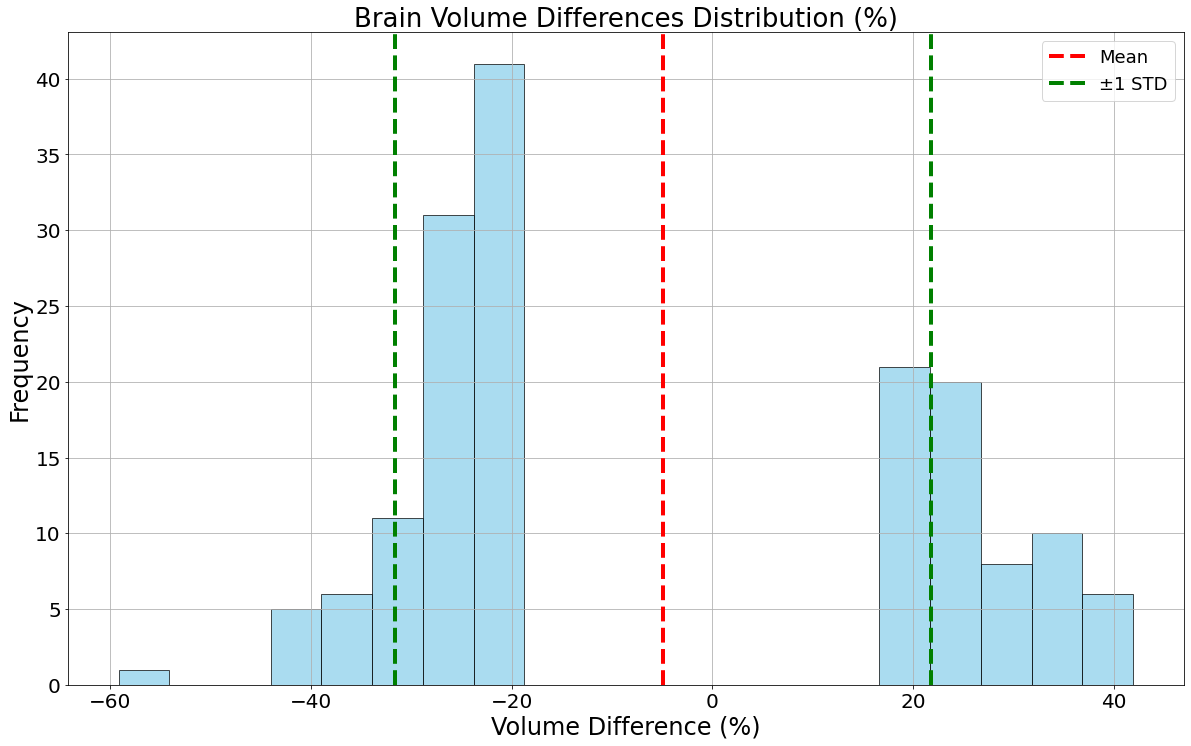

Mean Volume Difference (%): -4.956284890582741
Standard Deviation: 26.68726624802656
讀取的大腦總數:  160
成功左右腦比對總數量:  160
左腦>右腦的數量: 95 個 百分比: 59.375 %
左腦<右腦的數量: 65 個 百分比: 40.625 %
左腦和右腦差異: 18.75 %


In [38]:
# Step12 先繪製大腦的體積誤差率分布圖
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import tifffile as tif
from skimage import measure
from scipy import ndimage
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
start_time_seg = time.time()
# NAS路徑設定
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'

# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()
# 過濾出以 "使用者程序_第五階段存檔內容" 開頭的資料夾
stage_five_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容')]

# 檢查當前資料夾有多少個 體積誤差百分比.npy 檔案
# 搜尋當前資料夾 尾巴有 體積誤差百分比.npy
finish_precentage_list = glob.glob(os.path.join('./', '758個人工驗證完成*體積誤差百分比.npy'))
finish_precentage_list.sort()
# =
finish_filename_list = glob.glob(os.path.join('./', '758個人工驗證完成*有處理的檔案名稱.npy'))
finish_filename_list.sort()

# 將體積誤差百分比(絕對值)繪製分布圖 ================這是繪製單一個1000個大腦的體積誤差率分布圖
# Initialize empty lists to store the loaded arrays
absolute_percentage_differences = []
used_files = []

# Load and concatenate the arrays for volume percentage differences
for file in finish_precentage_list:
    data = np.load(file)
    absolute_percentage_differences.append(data)

# Concatenate all arrays into one
absolute_percentage_differences = np.concatenate(absolute_percentage_differences, axis=0)

# Load and concatenate the arrays for used file names
for file in finish_filename_list:
    data = np.load(file)
    used_files.append(data)

# Concatenate all arrays into one
used_files = np.concatenate(used_files, axis=0)


# 计算百分比差异的平均值和标准差
mean_difference = np.mean(absolute_percentage_differences)
std_deviation = np.std(absolute_percentage_differences)

# 绘制体积差异百分比的分布图
plt.figure(figsize=(20, 12))
plt.hist(absolute_percentage_differences, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_difference, color='r', linestyle='dashed', linewidth=4, label='Mean')
plt.axvline(mean_difference - std_deviation, color='g', linestyle='dashed', linewidth=4, label='±1 STD')
plt.axvline(mean_difference + std_deviation, color='g', linestyle='dashed', linewidth=4)

plt.title('Brain Volume Differences Distribution (%)',size=26)
plt.xlabel('Volume Difference (%)',size=24)
plt.ylabel('Frequency',size=24)
plt.xticks(fontsize=20)  # X轴刻度字体大小
plt.yticks(fontsize=20)  # Y轴刻度字体大小
plt.grid(True)
plt.legend(fontsize='18')

# 显示图表
plt.show()

# # 计算左脑体积大（即百分比差异<0）和右脑体积大（即百分比差异>0）的数量
# left_larger = sum(diff < 0 for diff in percentage_differences)
# right_larger = sum(diff > 0 for diff in percentage_differences)

# print(f"Number of cases where the left brain is larger: {left_larger}")
# print(f"Number of cases where the right brain is larger: {right_larger}")


# 打印平均值和标准差
print(f"Mean Volume Difference (%): {mean_difference}")
print(f"Standard Deviation: {std_deviation}")
print('讀取的大腦總數: ',len(absolute_percentage_differences))
print('成功左右腦比對總數量: ',len(absolute_percentage_differences))
# print('成功左右腦比對百分比: ',len(absolute_percentage_differences)/(len(absolute_percentage_differences))*100,'%')
# print('*成功比對的總數只有5成的主因: 已經去除[失敗、單邊MB、兩個MB有相連]')
# print('**大多數去除的來自於單邊MB & 兩個MB有相連(細微相連也會被排除)')
print('===============')
# # 假设 absolute_percentage_differences 已经被定义并包含了所有元素的绝对值
# count_greater_than_10 = len([x for x in absolute_percentage_differences if x >= 10 ])
# print('體積差異>10%數量:',count_greater_than_10, '個 百分比:',count_greater_than_10/len(absolute_percentage_differences)*100,'%')
# count_greater_than_20 = len([x for x in absolute_percentage_differences if x >= 20])
# print('體積差異>20%數量:',count_greater_than_20, '個 百分比:',count_greater_than_20/len(absolute_percentage_differences)*100,'%')
# count_greater_than_30 = len([x for x in absolute_percentage_differences if x >= 30])
# print('體積差異>30%數量:',count_greater_than_30, '個 百分比:',count_greater_than_30/len(absolute_percentage_differences)*100,'%')
# count_greater_than_40 = len([x for x in absolute_percentage_differences if x >= 40])
# print('體積差異>40%數量:',count_greater_than_40, '個 百分比:',count_greater_than_40/len(absolute_percentage_differences)*100,'%')
# count_greater_than_50 = len([x for x in absolute_percentage_differences if x >= 50])
# print('體積差異>50%數量:', count_greater_than_50, '個 百分比:', count_greater_than_50 / len(absolute_percentage_differences) * 100, '%')
# count_greater_than_60 = len([x for x in absolute_percentage_differences if x >= 60])
# print('體積差異>60%數量:', count_greater_than_60, '個 百分比:', count_greater_than_60 / len(absolute_percentage_differences) * 100, '%')
count_greater_left_big = len([x for x in absolute_percentage_differences if x <= 0 ])
print('左腦>右腦的數量:',count_greater_left_big,'個 百分比:',round(count_greater_left_big/len(absolute_percentage_differences)*100,3),'%')
count_greater_right_big = len([x for x in absolute_percentage_differences if x >= 0 ])
print('左腦<右腦的數量:',count_greater_right_big,'個 百分比:',round(count_greater_right_big/len(absolute_percentage_differences)*100,3),'%')

print('左腦和右腦差異:',round(abs(count_greater_left_big/len(absolute_percentage_differences)-count_greater_right_big/len(absolute_percentage_differences))*100,3),'%')
# =======================================================
# 先評估10% 以上的數量 和 20%以上的數量，
# 將百分比閾值以上的體積誤差率輸出DLG & SEG投影圖(參考Step6輸出2D合併圖、最後在使用網頁提供人工確認(Step7))

In [29]:
np.where(absolute_percentage_differences>40)

(array([42]),)

In [30]:
used_files[np.where(absolute_percentage_differences>=40)]

array(['Seg_MB_Gad1-F-700109'], dtype='<U21')

In [31]:
np.where(absolute_percentage_differences<-40)

(array([ 65, 118, 119, 121, 132]),)

In [32]:
used_files[np.where(absolute_percentage_differences<=-40)]

array(['Seg_MB_Tdc2-F-100017', 'Seg_MB_E0585-F-100023',
       'Seg_MB_E0585-F-200000', 'Seg_MB_E0585-F-200001',
       'Seg_MB_E0585-F-300040'], dtype='<U21')

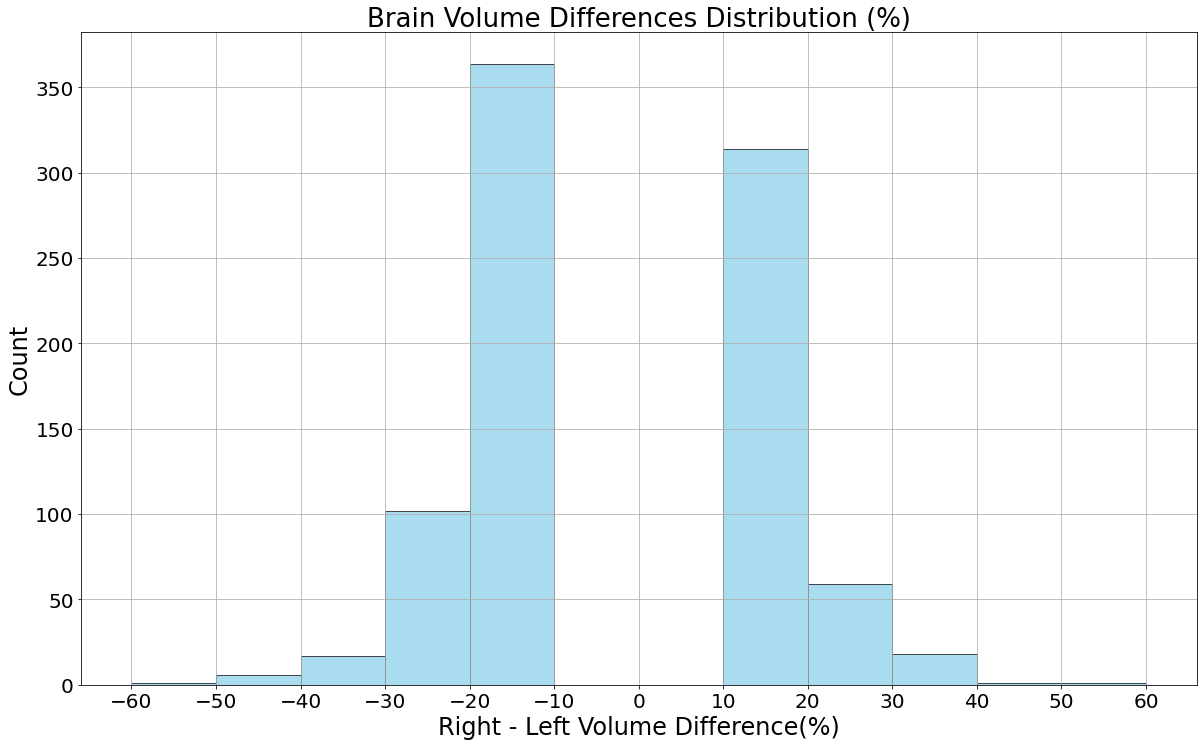

Mean Volume Difference (%): -2.0994599443466435
Standard Deviation: 17.97238364407199
讀取的大腦總數:  883
成功左右腦比對總數量:  883
左腦>右腦的數量: 490 個 百分比: 55.493 %
左腦<右腦的數量: 393 個 百分比: 44.507 %
左腦和右腦差異: 10.985 %
抽樣人工驗證發現大約只有84.2% 是可用於分析左右腦( 10337*0.84.2 = 8703個大腦 )
左右腦體積差異大於10%的總數 883個
佔總百分比: 883/8703 *100% = 10.14%


In [1]:
# ============2024/03/27============
# ========將三個結果結合再一起: 共165+541+182= 888個>10%========
# 讀取的大腦總數:  22835
# 成功左右腦比對總數量:  10337
# 但是抽樣人工驗證發現大約只有83% 是可用於分析左右腦( 10337*0.83 = 8579 )
# 左右腦體積差異大於10%的總數 888個，佔總百分比: 888/8579 *100% = 10.35%
# ======================繪製888個左右腦體積差異分布圖======================
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import tifffile as tif
from skimage import measure
from scipy import ndimage
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

# NAS路徑設定
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'

# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()
# 過濾出以 "使用者程序_第五階段存檔內容" 開頭的資料夾
stage_five_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容')]

# 檢查當前資料夾有多少個 體積誤差百分比.npy 檔案
# 搜尋當前資料夾 尾巴有 體積誤差百分比.npy
finish_precentage_list = glob.glob(os.path.join('./', '758個人工驗證完成*體積誤差百分比.npy'))

# 新增兩組 finish_precentage_list
finish_precentage_list += glob.glob(os.path.join('./', '0_1331個人工驗證完成*體積誤差百分比.npy'))
finish_precentage_list += glob.glob(os.path.join('./', '0_315個人工驗證完成*體積誤差百分比.npy'))
finish_precentage_list.sort()
# =============
finish_filename_list = glob.glob(os.path.join('./', '758個人工驗證完成*有處理的檔案名稱.npy'))
# 新增兩組 finish_filename_list
finish_filename_list += glob.glob(os.path.join('./', '0_1331個人工驗證完成*有處理的檔案名稱.npy'))
finish_filename_list += glob.glob(os.path.join('./', '0_315個人工驗證完成*有處理的檔案名稱.npy'))
finish_filename_list.sort()




# 將體積誤差百分比(絕對值)繪製分布圖
# Initialize empty lists to store the loaded arrays
absolute_percentage_differences = []
used_files = []


# Load and concatenate the arrays for volume percentage differences
for file in finish_precentage_list:
    data = np.load(file)
    absolute_percentage_differences.append(data)

# Concatenate all arrays into one
absolute_percentage_differences = np.concatenate(absolute_percentage_differences, axis=0)

# Load and concatenate the arrays for used file names
for file in finish_filename_list:
    data = np.load(file)
    used_files.append(data)

# Concatenate all arrays into one
used_files = np.concatenate(used_files, axis=0)


# 计算百分比差异的平均值和标准差
mean_difference = np.mean(absolute_percentage_differences)
std_deviation = np.std(absolute_percentage_differences)

# # 绘制体积差异百分比的分布图
# plt.figure(figsize=(20, 12))
# plt.hist(absolute_percentage_differences, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
# 将大于60的值设置为60
clipped_differences = np.clip(absolute_percentage_differences, None, 60)
plt.figure(figsize=(20, 12))
plt.hist(clipped_differences, bins=12, range=(-60, 60), color='skyblue', edgecolor='black', alpha=0.7)
# plt.axvline(mean_difference, color='r', linestyle='dashed', linewidth=4, label='Mean')
# plt.axvline(mean_difference - std_deviation, color='g', linestyle='dashed', linewidth=4, label='±1 STD')
# plt.axvline(mean_difference + std_deviation, color='g', linestyle='dashed', linewidth=4)

# plt.axvline(mean_difference - 2*std_deviation, color='orange', linestyle='dashed', linewidth=4, label='±2 STD')
# plt.axvline(mean_difference + 2*std_deviation, color='orange', linestyle='dashed', linewidth=4)

# plt.axvline(mean_difference - 3*std_deviation, color='purple', linestyle='dashed', linewidth=4, label='±3 STD')
# plt.axvline(mean_difference + 3*std_deviation, color='purple', linestyle='dashed', linewidth=4)

plt.title('Brain Volume Differences Distribution (%)',size=26)
plt.xlabel('Right - Left Volume Difference(%)',size=24)
plt.ylabel('Count',size=24)
# plt.xticks(fontsize=20)  # X轴刻度字体大小
plt.xticks(np.arange(-60, 61, 10), fontsize=20)  # 设置X轴刻度
plt.yticks(fontsize=20)  # Y轴刻度字体大小
plt.grid(True)
# plt.legend(fontsize='18')

# 显示图表
plt.show()

# # 计算左脑体积大（即百分比差异<0）和右脑体积大（即百分比差异>0）的数量
# left_larger = sum(diff < 0 for diff in percentage_differences)
# right_larger = sum(diff > 0 for diff in percentage_differences)

# print(f"Number of cases where the left brain is larger: {left_larger}")
# print(f"Number of cases where the right brain is larger: {right_larger}")


# 打印平均值和标准差
print(f"Mean Volume Difference (%): {mean_difference}")
print(f"Standard Deviation: {std_deviation}")
print('讀取的大腦總數: ',len(absolute_percentage_differences))
print('成功左右腦比對總數量: ',len(absolute_percentage_differences))
# print('成功左右腦比對百分比: ',len(absolute_percentage_differences)/(len(absolute_percentage_differences))*100,'%')
# print('*成功比對的總數只有5成的主因: 已經去除[失敗、單邊MB、兩個MB有相連]')
# print('**大多數去除的來自於單邊MB & 兩個MB有相連(細微相連也會被排除)')
print('===============')
count_greater_left_big = len([x for x in absolute_percentage_differences if x <= 0 ])
print('左腦>右腦的數量:',count_greater_left_big,'個 百分比:',round(count_greater_left_big/len(absolute_percentage_differences)*100,3),'%')
count_greater_right_big = len([x for x in absolute_percentage_differences if x >= 0 ])
print('左腦<右腦的數量:',count_greater_right_big,'個 百分比:',round(count_greater_right_big/len(absolute_percentage_differences)*100,3),'%')

print('左腦和右腦差異:',round(abs(count_greater_left_big/len(absolute_percentage_differences)-count_greater_right_big/len(absolute_percentage_differences))*100,3),'%')
# =======================================================
# 先評估10% 以上的數量 和 20%以上的數量，
# 將百分比閾值以上的體積誤差率輸出DLG & SEG投影圖(參考Step6輸出2D合併圖、最後在使用網頁提供人工確認(Step7))
print('===============')

print('抽樣人工驗證發現大約只有84.2% 是可用於分析左右腦( 10337*0.84.2 = 8703個大腦 )')
print('左右腦體積差異大於10%的總數 883個')
print('佔總百分比: 883/8703 *100% = 10.14%')

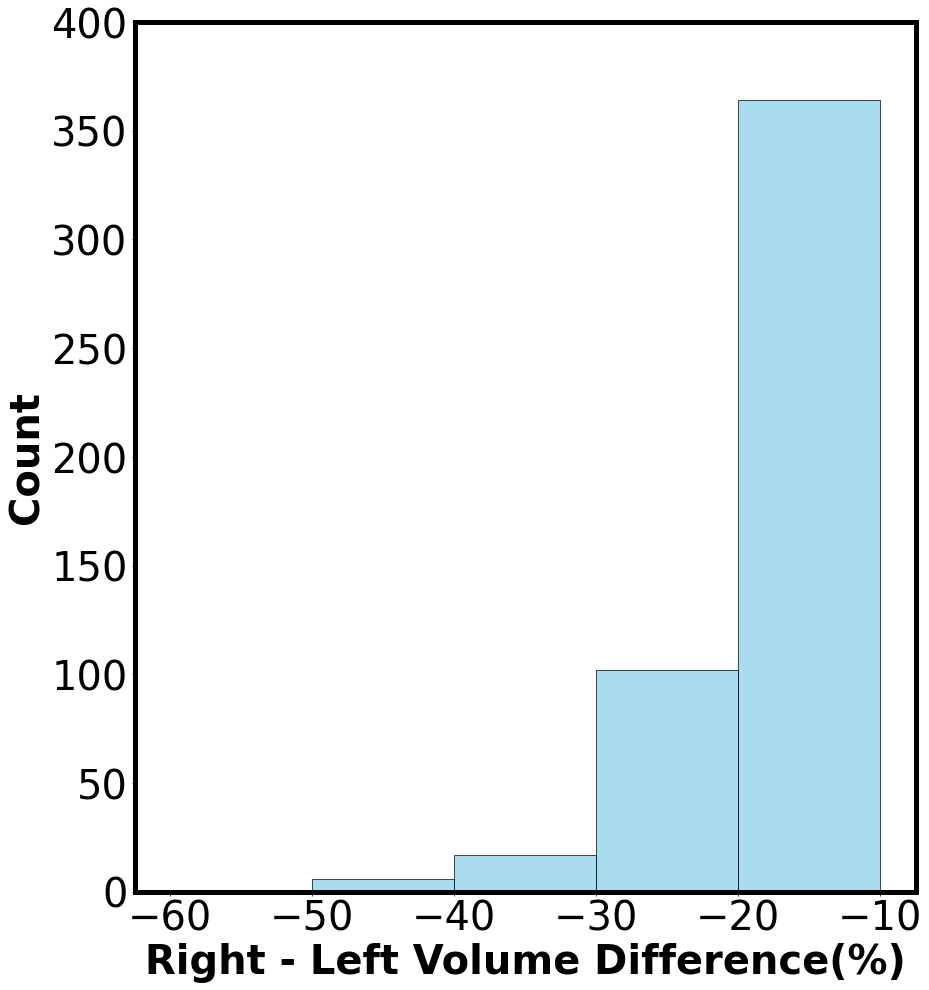

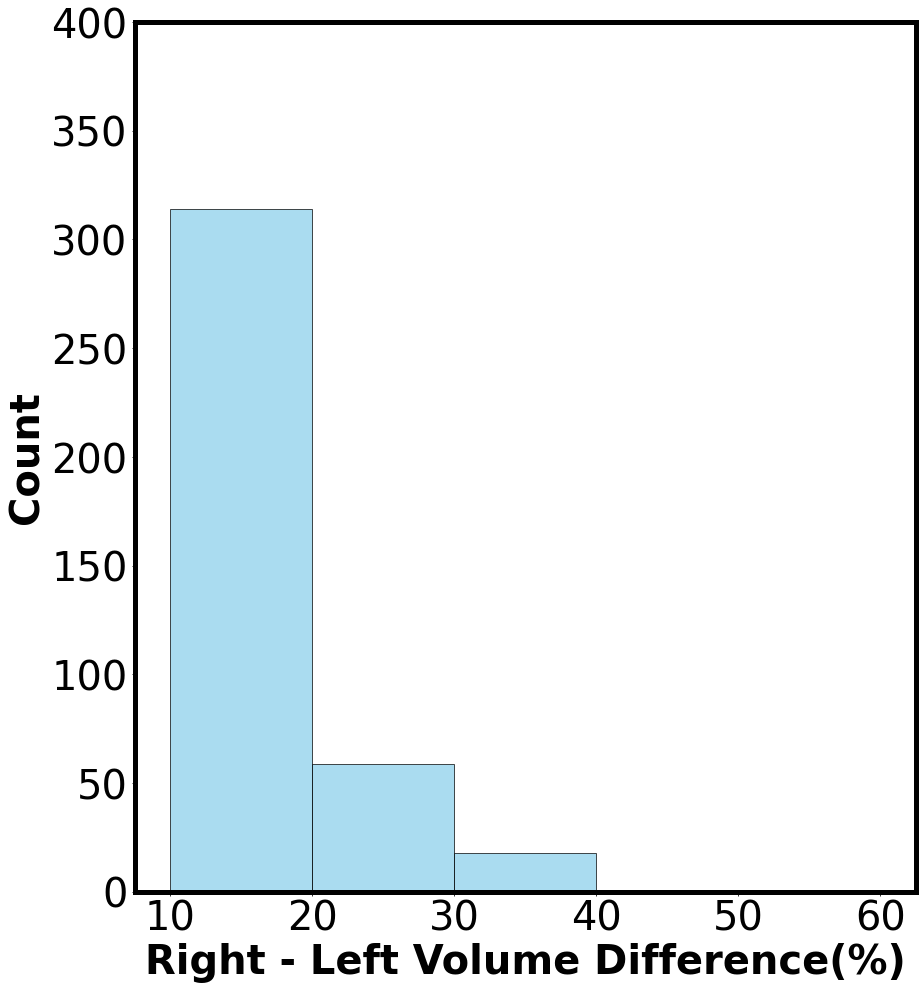

In [14]:
# ==============2024/04/26 依照老師要求拆成左右兩張圖
import numpy as np
import matplotlib.pyplot as plt

# 假設 absolute_percentage_differences 是你已經有的數據
clipped_differences = np.clip(absolute_percentage_differences, None, 60)

# 分別篩選兩個範圍的數據
data_negative = clipped_differences[(clipped_differences >= -60) & (clipped_differences <= -10)]
data_positive = clipped_differences[(clipped_differences >= 10) & (clipped_differences <= 60)]

# 繪製 -60 到 -10 的範圍
plt.figure(figsize=(14, 16))
plt.hist(data_negative, bins=5, range=(-60, -10), color='skyblue', edgecolor='black', alpha=0.7)
# plt.title('Brain Volume Differences Distribution (-60% to -10%)', size=26)
plt.xlabel('Right - Left Volume Difference(%)', size=40, fontweight='bold')
plt.ylabel('Count', size=40, fontweight='bold')
plt.xticks(np.arange(-60, -9, 10), fontsize=40)
plt.yticks(fontsize=40)
plt.ylim(0, 400)  # 統一 Y 軸範圍
# plt.grid(True)
# 加粗外邊框
ax = plt.gca()  # 獲取當前的Axes對象ax
for spine in ax.spines.values():
    spine.set_linewidth(5)  # 設定邊框線的寬度
plt.show()

# 繪製 10 到 60 的範圍
plt.figure(figsize=(14, 16))
plt.hist(data_positive, bins=5, range=(10, 60), color='skyblue', edgecolor='black', alpha=0.7)
# plt.title('Brain Volume Differences Distribution (10% to 60%)', size=26)
plt.xlabel('Right - Left Volume Difference(%)', size=40, fontweight='bold')
plt.ylabel('Count', size=40, fontweight='bold')
plt.xticks(np.arange(10, 61, 10), fontsize=40)
plt.yticks(fontsize=40)
plt.ylim(0, 400)  # 統一 Y 軸範圍
# plt.grid(True)
# 加粗外邊框
ax = plt.gca()  # 獲取當前的Axes對象ax
for spine in ax.spines.values():
    spine.set_linewidth(5)  # 設定邊框線的寬度
plt.show()

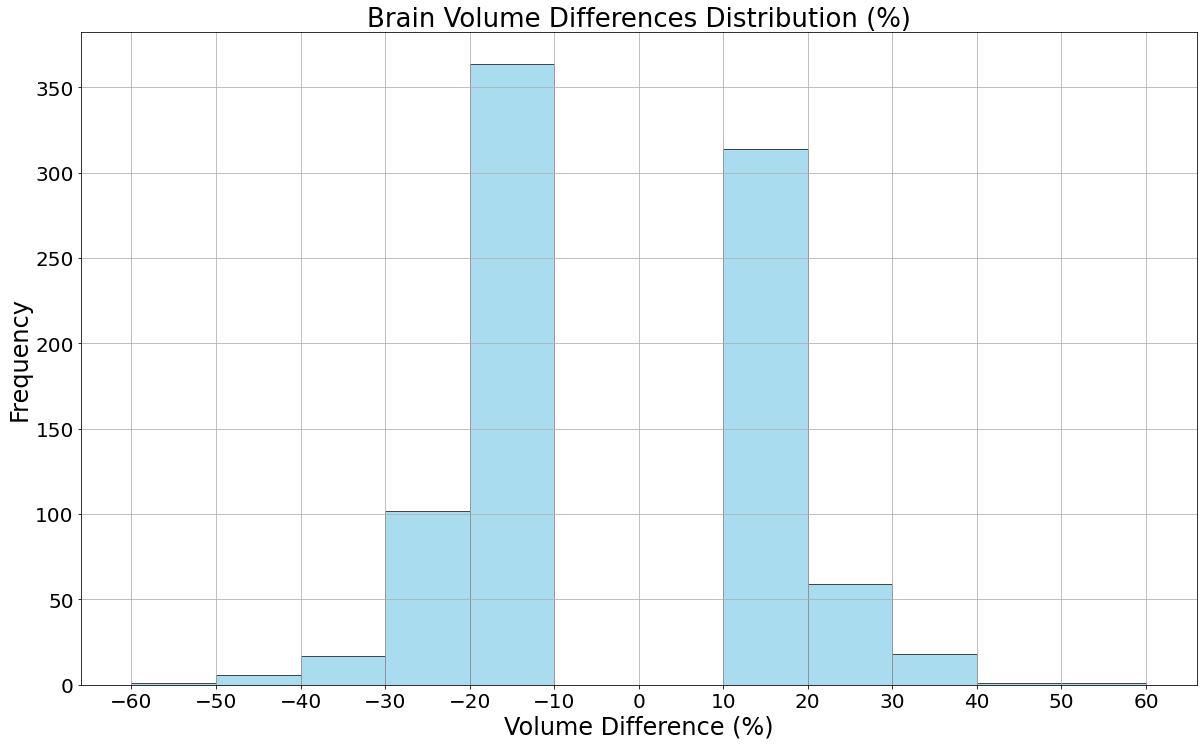

In [7]:
# 将大于60的值设置为60
clipped_differences = np.clip(absolute_percentage_differences, None, 60)
plt.figure(figsize=(20, 12))
plt.hist(clipped_differences, bins=12, range=(-60, 60), color='skyblue', edgecolor='black', alpha=0.7)
# plt.axvline(mean_difference, color='r', linestyle='dashed', linewidth=4, label='Mean')
# plt.axvline(mean_difference - std_deviation, color='g', linestyle='dashed', linewidth=4, label='±1 STD')
# plt.axvline(mean_difference + std_deviation, color='g', linestyle='dashed', linewidth=4)

# plt.axvline(mean_difference - 2*std_deviation, color='orange', linestyle='dashed', linewidth=4, label='±2 STD')
# plt.axvline(mean_difference + 2*std_deviation, color='orange', linestyle='dashed', linewidth=4)

# plt.axvline(mean_difference - 3*std_deviation, color='purple', linestyle='dashed', linewidth=4, label='±3 STD')
# plt.axvline(mean_difference + 3*std_deviation, color='purple', linestyle='dashed', linewidth=4)

plt.title('Brain Volume Differences Distribution (%)', size=26)
plt.xlabel('Volume Difference (%)', size=24)
plt.ylabel('Frequency', size=24)
plt.xticks(np.arange(-60, 61, 10), fontsize=20)  # 設置X軸刻度
plt.yticks(fontsize=20)  # Y軸刻度字體大小
plt.grid(True)
# plt.legend(fontsize='18')


In [9]:
# 2024/04/09
np.save('一號模型結果_883個左右腦體積差異大於10_大腦編號',used_files)
np.save('一號模型結果_883個左右腦體積差異大於10_百分比數值',absolute_percentage_differences)


60.091386622566304

In [13]:
# 尋找特定大腦對應的左右腦差異百分比 (目前尋找有全腦DLG 而且左右腦差異>10%)
target_brain_postion = np.where(used_files == "Seg_MB_Tdc2-F-100020")
absolute_percentage_differences[target_brain_postion] #  右>左 38%
target_brain_postion = np.where(used_files == "Seg_MB_fru-F-100023")
absolute_percentage_differences[target_brain_postion]
target_brain_postion = np.where(used_files == "Seg_MB_fru-F-100024")
absolute_percentage_differences[target_brain_postion] # 左>右 21.56%
target_brain_postion = np.where(used_files == "Seg_MB_VGlut-F-500851")
absolute_percentage_differences[target_brain_postion]# 左>右 13%

array([-13.13763009])

In [ ]:
# =================================

In [3]:
# 2024/04/03 調閱三張全腦影像，進行人工切割中線
# 目標大腦名稱: Tdc2-F-100020 、 fru-F-100023 、 VGlut-F-500851
# 先讀取 3D DLG 在投影成2D檢查
# 建立三個大腦名稱的列表
three_brains_names = ['Seg_MB_Tdc2-F-100020','Seg_MB_fru-F-100023','Seg_MB_VGlut-F-500851']



# Step1 先找到需要翻轉和不用翻轉的檔案的絕對路徑
import os
import tifffile as tif
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'

# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()
# 假定的 NAS 路徑
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'

# 搜尋並映射檔案路徑
def find_file_paths(file_names, search_folders, nas_path):
    file_paths = {}
    for file_name in file_names:
        file_name_with_ext = file_name+'.tif'
#         file_name_with_ext = file_name  # 假定檔案名已包含副檔名
        found = False
        for folder in search_folders:
            potential_path = os.path.join(nas_path, folder, file_name_with_ext)
            if os.path.exists(potential_path):
                file_paths[file_name] = potential_path
                found = True
                break
    return file_paths

# 需要搜尋的資料夾列表
# 過濾出以 "使用者程序_第五階段存檔內容" 開頭的資料夾
search_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容')]

# 尋找並建立路徑列表
No_Need_to_flip_path_list = find_file_paths(three_brains_names, search_folders, nas_path)

# 從 No_Need_to_flip_path_list 字典中提取絕對路徑
no_need_to_flip_path_values = list(No_Need_to_flip_path_list.values())


In [17]:
# 找到原始DLG和對應的Seg
# 手動輸入要讀取的大腦編號
three_brains_names = ['Seg_MB_Tdc2-F-100020','Seg_MB_fru-F-100023','Seg_MB_VGlut-F-500851']
# 用於存儲檔案路徑的字典
file_paths = {}

# 遍歷檔案名稱列表
for file_name in three_brains_names:
    # filename 沒有包含附檔案名稱
    file_name_with_tif = file_name+'.tif'
    found = False
    # 對每個檔案名稱，檢查所有資料夾
    for folder in stage_five_folders:
        potential_path = os.path.join(nas_path, folder, file_name_with_tif)
        # 檢查檔案是否存在於當前資料夾
        if os.path.exists(potential_path):
            file_paths[file_name] = potential_path
            found = True
            break

# # 打印結果或進行後續處理
# for file_name, path in file_paths.items():
#     print(f"{file_name}: {path}")
# 已經提取到 758個檔案的SEG路徑
print('已經提取到',len(three_brains_names),'個檔案的SEG路徑')
print('請將提取到的數字和上面分布圖的統計數字比對是否相等')

已經提取到 3 個檔案的SEG路徑
請將提取到的數字和上面分布圖的統計數字比對是否相等


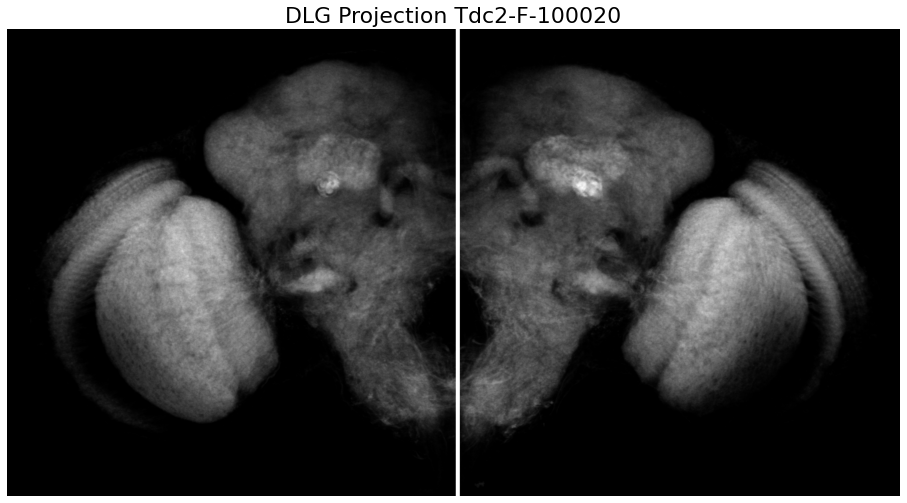

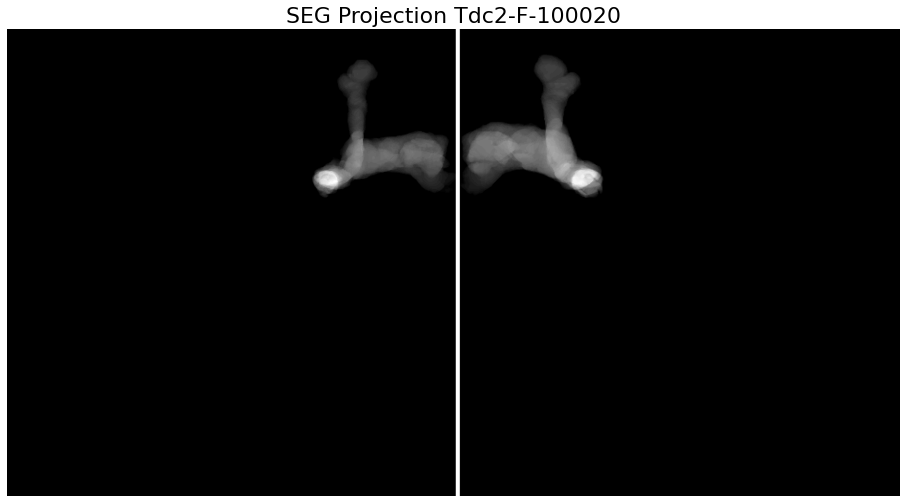

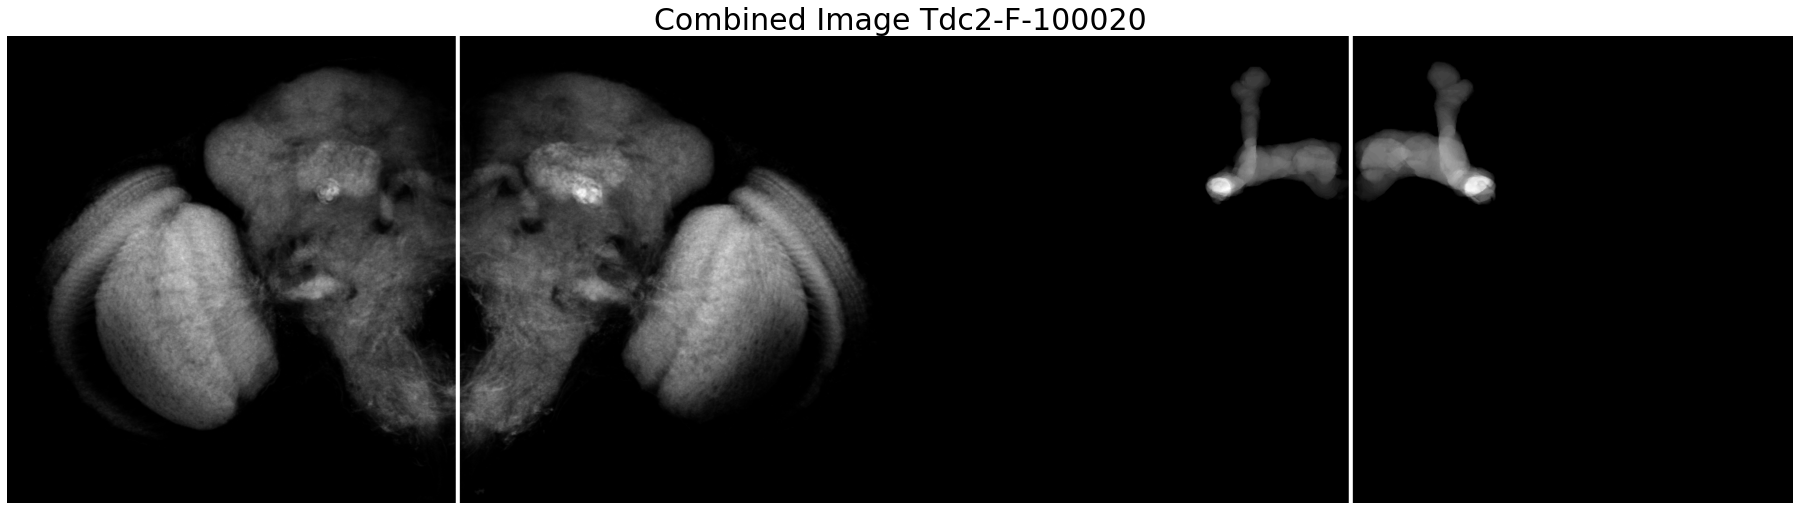

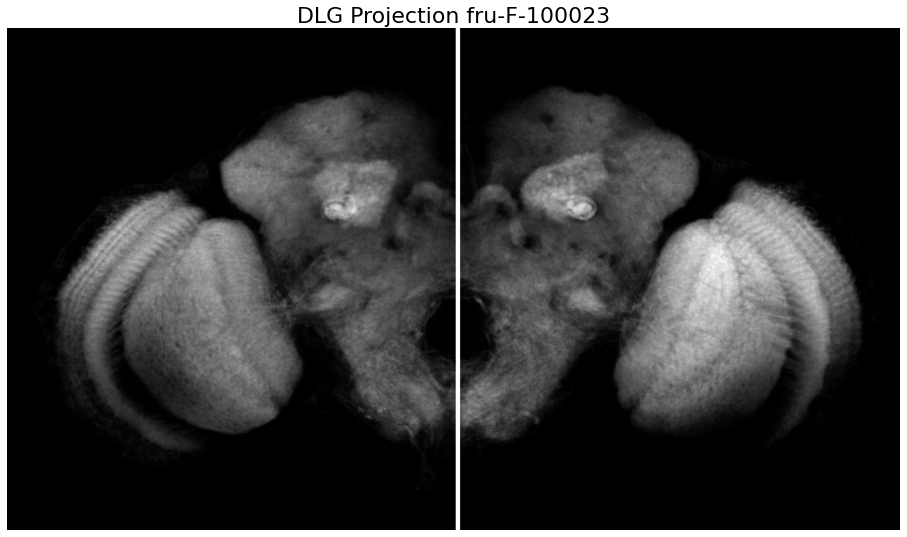

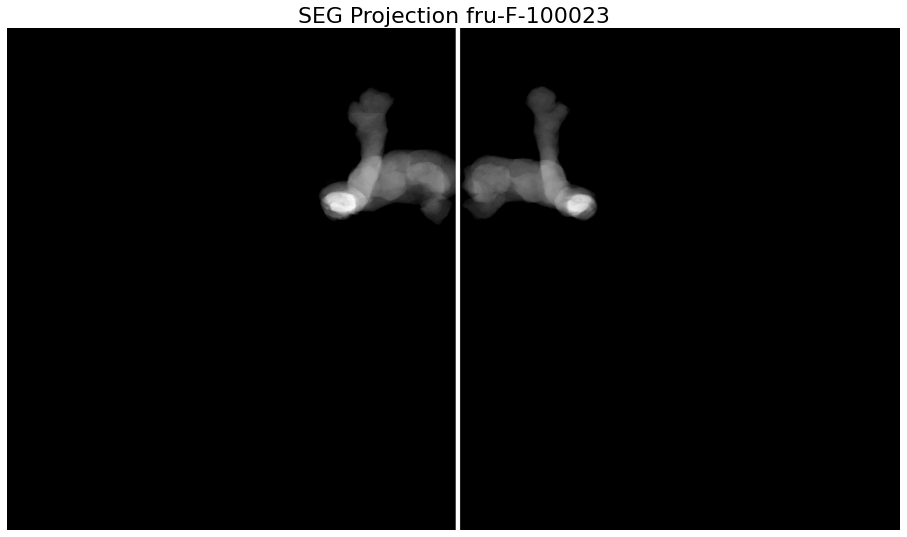

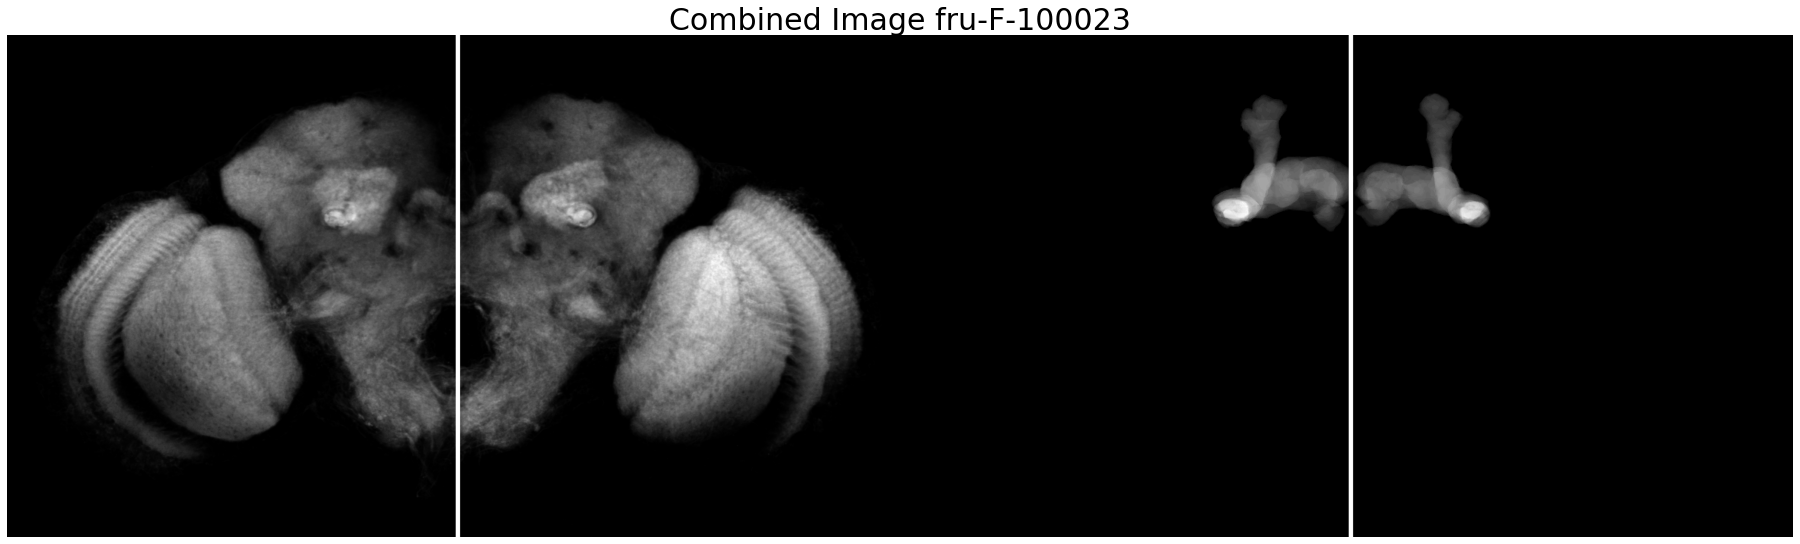

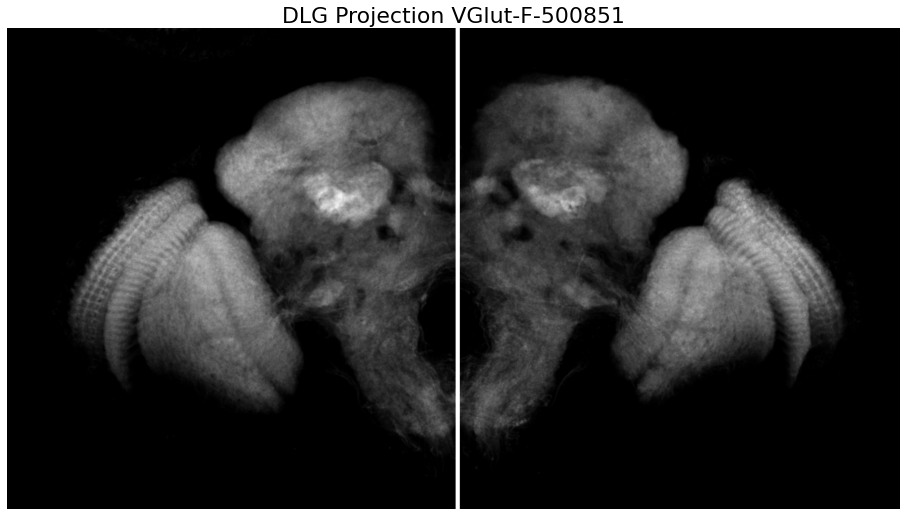

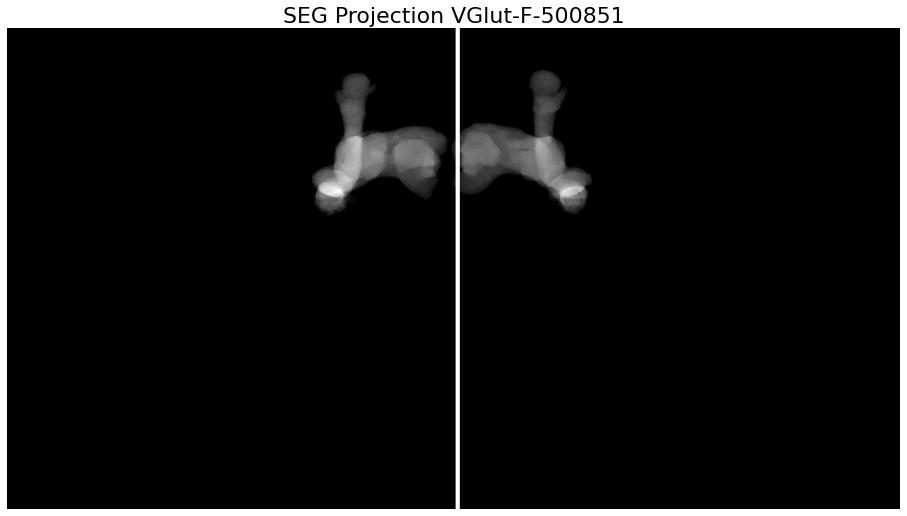

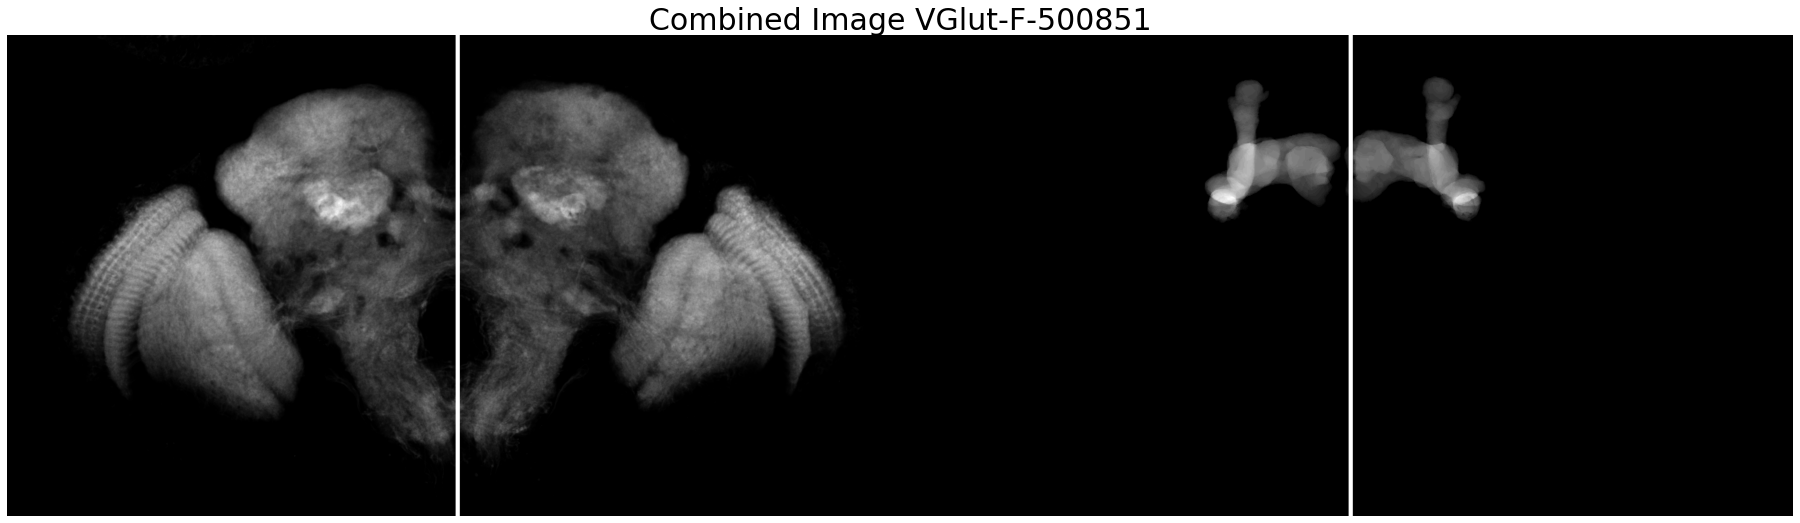

In [66]:
# 顯示三張合併的2D圖片
import numpy as np
import os
from PIL import Image
import tifffile as tif
import time  # 導入 time 模塊
# 确保在 notebook 中嵌入图像
%matplotlib inline
def normalize_image(image):
    """
    归一化图像到0到255的范围。
    """
    # 计算图像的最大值和最小值
    min_val = np.min(image)
    max_val = np.max(image)
    # 归一化到0-1
    normalized_image = (image - min_val) / (max_val - min_val)
    # 缩放到0-255并转换为整数
    scaled_image = (normalized_image * 255).astype(np.uint8)
    return scaled_image
# def plot_with_center_line(image, title='Image with Center Line'):
#     """
#     显示图像并在中心绘制一条线。
#     """
#     plt.figure(figsize=(8, 8))
#     plt.imshow(image, cmap='gray')
#     plt.axvline(x=image.shape[1] // 2, color='yellow')  # 在图像中心绘制黄色垂直线
#     plt.title(title)
#     plt.axis('off')
#     plt.show()
    
# def add_center_line(image):
#     """
#     在图像中心绘制黄色线，并返回带有中心线的图像。
#     """
#     image_with_line = image.copy()
#     center_col = image.shape[1] // 2
#     image_with_line[:, center_col] = 255  # 假设图像已经归一化到0-255，使用255代表黄色线
#     return image_with_line
def add_center_line(image, line_width=8):
    """
    在图像中心绘制黄色线，并返回带有中心线的图像。
    参数:
    image: 输入图像
    line_width: 线条的宽度（以像素为单位）
    """
    image_with_line = image.copy()
    center_col = (image.shape[1] // 2)+9
    start_col = max(center_col - line_width // 2, 0)
    end_col = min(center_col + line_width // 2 + 1, image.shape[1])

    # 将线条宽度设置为 line_width 像素
    image_with_line[:, start_col:end_col] = 255  # 假设图像已经归一化到0-255，使用255代表黄色线
    return image_with_line


start_time = time.time()  # 記錄迴圈開始的時間
for file_name in three_brains_names:
    seg_path = file_paths[file_name]
    # 將Seg路徑替換為DLG路徑
    dlg_path = seg_path.replace('Seg_MB', 'DLG')
    
    # 讀取圖像
    dlg_image = tif.imread(dlg_path)
    seg_image = tif.imread(seg_path)
    
    # 投影和归一化图像
    dlg_projection = np.sum(dlg_image[:len(dlg_image)//3, :, :], axis=0)
    seg_projection = np.sum(seg_image, axis=0)
    
    dlg_projection_normalized = normalize_image(dlg_projection)
    seg_projection_normalized = normalize_image(seg_projection)
    # 在 DLG 和 SEG 投影图像上添加中心线
    dlg_projection_with_line = add_center_line(dlg_projection_normalized)
    seg_projection_with_line = add_center_line(seg_projection_normalized)
    
    # 合并图像
    combined_image = np.concatenate((dlg_projection_normalized, seg_projection_normalized), axis=1)
    
    # 合并带有中心线的图像
    combined_image_with_line = np.concatenate((dlg_projection_with_line, seg_projection_with_line), axis=1)

#     # 显示 dlg_projection_normalized 图像
#     plt.figure(figsize=(8, 8))
#     plt.imshow(dlg_projection_normalized, cmap='gray')
#     plt.title("DLG Projection Normalized")
#     plt.axis('off')  # 不显示坐标轴
#     plt.show()

#     # 显示 seg_projection_normalized 图像
#     plt.figure(figsize=(8, 8))
#     plt.imshow(seg_projection_normalized, cmap='gray')
#     plt.title("SEG Projection Normalized")
#     plt.axis('off')  # 不显示坐标轴
#     plt.show()

#     # 显示 combined_image 图像
#     plt.figure(figsize=(16, 8))
#     plt.imshow(combined_image, cmap='gray')
#     plt.title("Combined Image")
#     plt.axis('off')  # 不显示坐标轴
#     plt.show()
# ==============================
    # 显示 dlg_projection_normalized 图像
    plt.figure(figsize=(16, 16))
    plt.imshow(dlg_projection_with_line, cmap='gray')
    plt.title("DLG Projection "+seg_path.split('_')[-1].split('.')[0],size=22)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

    # 显示 seg_projection_normalized 图像
    plt.figure(figsize=(16, 16))
    plt.imshow(seg_projection_with_line, cmap='gray')
    plt.title("SEG Projection "+seg_path.split('_')[-1].split('.')[0],size=22)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

    # 显示 combined_image 图像
    plt.figure(figsize=(32, 16))
    plt.imshow(combined_image_with_line, cmap='gray')
    plt.title("Combined Image "+seg_path.split('_')[-1].split('.')[0],size=30)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

In [43]:
seg_path.split('_')[-1].split('.')[0]

'VGlut-F-500851'

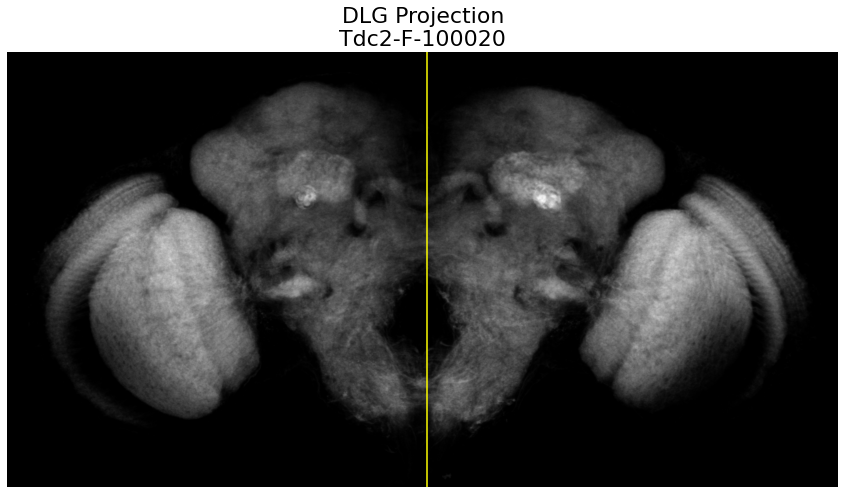

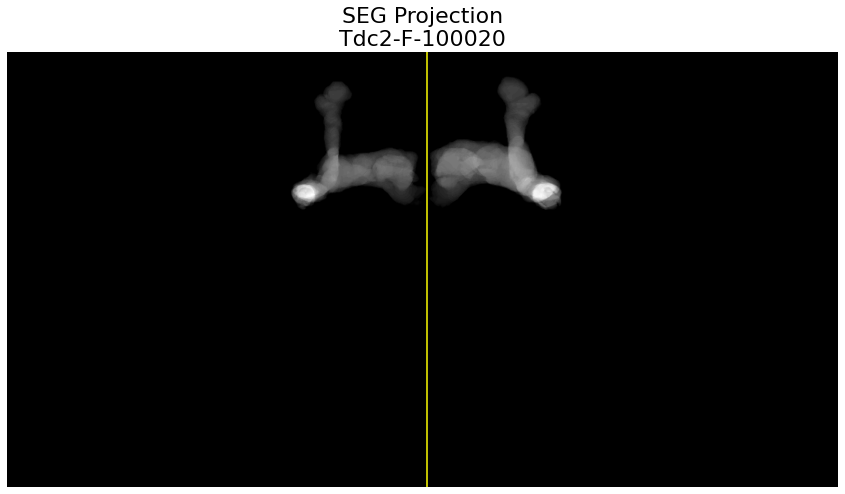

42068822 43438359 1369537 3.203326279695737


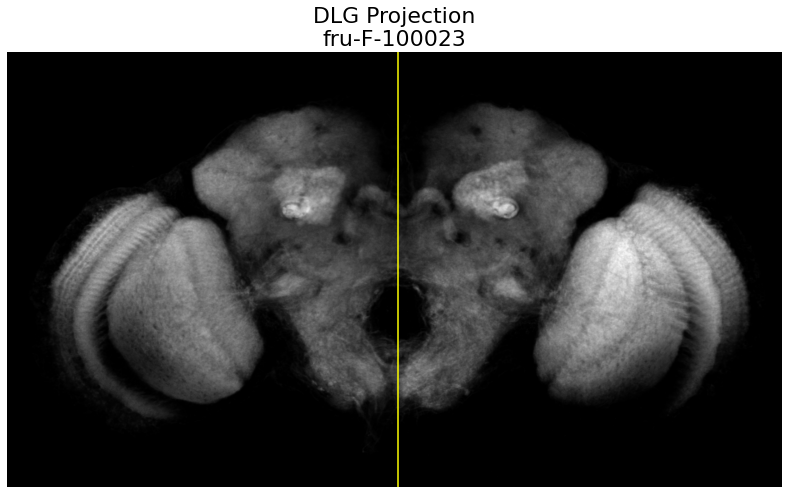

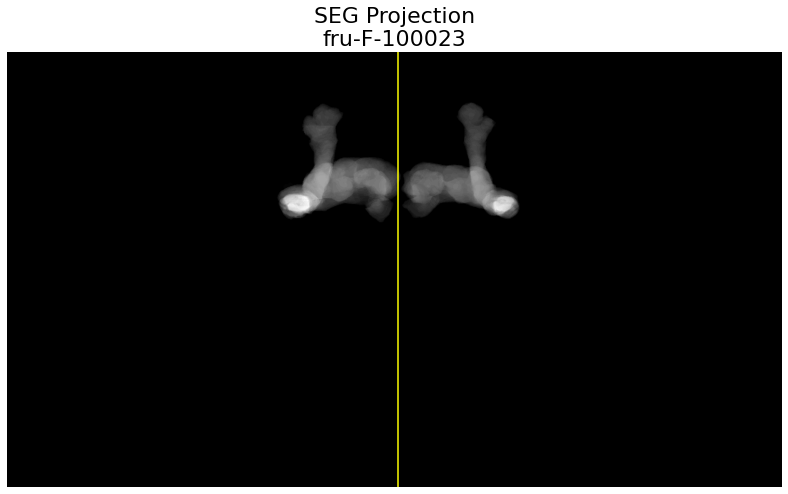

33426068 31354081 -2071987 -6.396981272766137


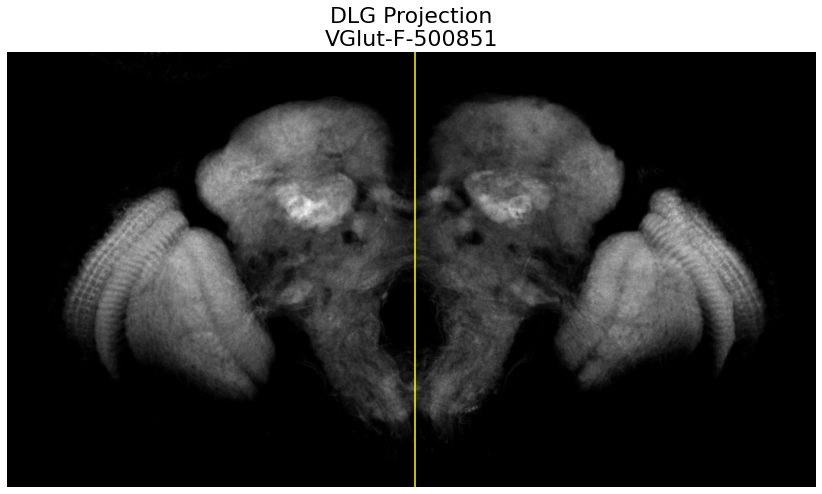

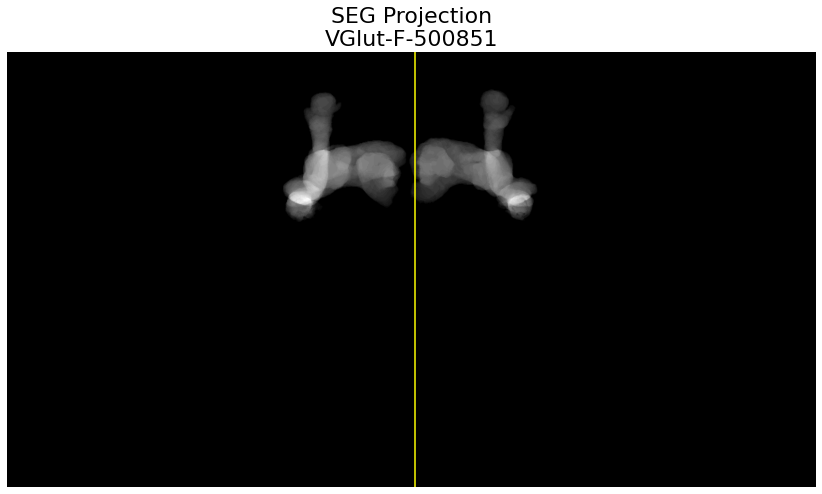

29235104 29596690 361586 1.229219697090998


In [79]:
# 繪製黃色線條版本
import matplotlib.pyplot as plt
import numpy as np

def plot_with_center_line(image, title='Image with Center Line'):
    """
    显示图像并在中心绘制一条线。
    """
    plt.figure(figsize=(16, 8))
    plt.imshow(image, cmap='gray')
    plt.axvline(x=(image.shape[1] // 2)+9, color='yellow')  # 在图像中心绘制黄色垂直线
    plt.title(title,size=22)
    plt.axis('off')
    plt.show()
    
    
def calculate_total_volume(image, threshold=0):
    """
    计算整个3D图像中亮度大于给定阈值的像素总数。

    参数:
    image: 输入的3D图像。
    threshold: 亮度阈值。
    """
    return (image > threshold).sum()
for file_name in three_brains_names:
    seg_path = file_paths[file_name]
    # 將Seg路徑替換為DLG路徑
    dlg_path = seg_path.replace('Seg_MB', 'DLG')
    
    # 讀取圖像
    dlg_image = tif.imread(dlg_path)
    seg_image = tif.imread(seg_path)
    # 投影和归一化图像
    dlg_projection = np.sum(dlg_image[:len(dlg_image)//3, :, :], axis=0)
    seg_projection = np.sum(seg_image, axis=0)
    
    dlg_projection_normalized = normalize_image(dlg_projection)
    seg_projection_normalized = normalize_image(seg_projection)
    
    
    
    # 在 dlg_projection_normalized 图像中显示中心线
    plot_with_center_line(dlg_projection_normalized, "DLG Projection\n"+seg_path.split('_')[-1].split('.')[0])
    # 在 seg_projection_normalized 图像中显示中心线
    plot_with_center_line(seg_projection_normalized, "SEG Projection\n"+seg_path.split('_')[-1].split('.')[0])


    # 切分 dlg_image 为左右两半
    center_index = (dlg_image.shape[2] // 2)+9  # 使用最后一个维度进行分割
    left_half = dlg_image[:, :, :center_index]
    right_half = dlg_image[:, :, center_index:]
    left_half = dlg_image[:, :, :center_index]
    right_half = dlg_image[:, :, center_index:]
    # 计算左右两侧的总体积
    left_total_volume = calculate_total_volume(left_half)
    right_total_volume = calculate_total_volume(right_half)

    # 计算体积差异及其百分比
    total_volume_difference = right_total_volume - left_total_volume
    total_percentage_difference = 100.0 * total_volume_difference / ((left_total_volume + right_total_volume) / 2.0)

    print(left_total_volume, right_total_volume, total_volume_difference, total_percentage_difference)
#     # 对左右两半进行投影
#     left_projection = np.sum(left_half, axis=0)
#     right_projection = np.sum(right_half, axis=0)

#     # 归一化左右投影图像
#     left_projection_normalized = normalize_image(left_projection)
#     right_projection_normalized = normalize_image(right_projection)

#     # 显示左半部分的投影
#     plt.figure(figsize=(8, 8))
#     plt.imshow(left_projection_normalized, cmap='gray')
#     plt.title("Left Half Projection")
#     plt.axis('off')
#     plt.show()

#     # 显示右半部分的投影
#     plt.figure(figsize=(8, 8))
#     plt.imshow(right_projection_normalized, cmap='gray')
#     plt.title("Right Half Projection")
#     plt.axis('off')
#     plt.show()


In [86]:
import pandas as pd

# Defining the data
data = {
    'Brain ID': ['Tdc2-F-100020', 'fru-F-100023', 'VGlut-F-500851'],
    'MB Neuropil Volume Difference (Left vs. Right)': ['38.00%', '-21.56%', '-13.13%'],
    'Total Brain DLG Volume Difference (Left vs. Right)': ['3.2%', '-6.4%', '1.2%']
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Setting the index
df.set_index('Brain ID', inplace=True)

# Displaying the table
df


,MB Neuropil Volume Difference (Left vs. Right),Total Brain DLG Volume Difference (Left vs. Right)
Brain ID,,
Tdc2-F-100020,38.00%,3.2%
fru-F-100023,-21.56%,-6.4%
VGlut-F-500851,-13.13%,1.2%


Slope: 0.8509341402931041


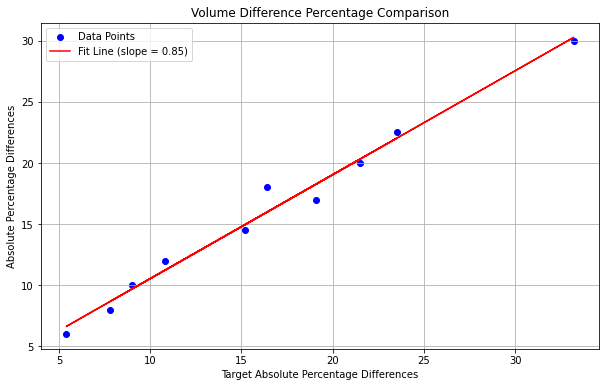

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 假设的大脑ID和体积差异百分比
target_files = np.array(['Seg_MB_A', 'Seg_MB_B', 'Seg_MB_C', 'Seg_MB_D', 'Seg_MB_E', 'Seg_MB_F', 'Seg_MB_G', 'Seg_MB_H', 'Seg_MB_I', 'Seg_MB_J'])
target_absolute_percentage_differences = np.array([-15.2, 23.5, 10.8, 5.4, 19.1, 33.2, 7.8, 16.4, 21.5, 9.0])
target_absolute_percentage_differences = abs(target_absolute_percentage_differences)
used_files = np.array(['Seg_MB_G', 'Seg_MB_A', 'Seg_MB_B', 'Seg_MB_H', 'Seg_MB_I', 'Seg_MB_F', 'Seg_MB_E', 'Seg_MB_C', 'Seg_MB_D', 'Seg_MB_J'])
absolute_percentage_differences = np.array([8.0, 14.5, 22.5, 18.0, 20.0, 30.0, 17.0, 12.0, 6.0, 10.0])

# 提取大脑ID
target_brain_ids = [s.split('_')[-1] for s in target_files]
used_brain_ids = [s.split('_')[-1] for s in used_files]

# 初始化 X 和 Y 坐标数组
x_coords = []
y_coords = []

# 匹配大脑ID并获取对应的百分比差异值
for i, brain_id in enumerate(target_brain_ids):
    if brain_id in used_brain_ids:
        index_in_used = used_brain_ids.index(brain_id)
        x_coords.append(target_absolute_percentage_differences[i])
        y_coords.append(absolute_percentage_differences[index_in_used])

# # 绘制 XY 图
# plt.figure(figsize=(10, 6))
# plt.scatter(x_coords, y_coords, color='blue')
# plt.title('Volume Difference Percentage Comparison')
# plt.xlabel('Target Absolute Percentage Differences')
# plt.ylabel('Absolute Percentage Differences')
# plt.grid(True)
# plt.show()

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

# 使用 numpy 的 polyfit 方法计算斜率和截距
slope, intercept = np.polyfit(x_coords, y_coords, 1)

# 打印斜率
print(f'Slope: {slope}')

# 绘制散点图和回归线
plt.figure(figsize=(10, 6))
plt.scatter(x_coords, y_coords, color='blue', label='Data Points')
plt.plot(x_coords, intercept + slope * x_coords, 'r-', label=f'Fit Line (slope = {slope:.2f})')
plt.title('Volume Difference Percentage Comparison')
plt.xlabel('Target Absolute Percentage Differences')
plt.ylabel('Absolute Percentage Differences')
plt.grid(True)
plt.legend()
plt.show()